<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

##### NIRISS AMI Pipeline Notebook

**Authors**: R. Cooper<br>
**Last Updated**: April 15, 2025<br>
**Pipeline Version**: 1.18.0 (Build 11.3)

**Purpose**:<br>
This notebook provides a framework for processing Near-Infrared
Imager and Slitless Spectrograph (NIRISS) Aperture Masking Interferometry (AMI) data through all
three James Webb Space Telescope (JWST) pipeline stages.  Data is assumed
to be located in one observation folder according to paths set up below.
It should not be necessary to edit any cells other than in the
[Configuration](#1.-Configuration) section unless modifying the standard
pipeline processing options.

**Data**:
This notebook uses an example dataset from
[Program ID](https://www.stsci.edu/jwst/science-execution/program-information)
1093 (PI: Thatte) which is the AMI commissioning program. For illustrative 
purposes, we will use a single target and reference star pair. Each exposure 
was taken in the F480W filter filter with the non-redundant mask (NRM) that 
enables AMI in the pupil. The observations used are
observation 12 for the target and observation 15 for the reference star.

Example input data to use will be downloaded automatically unless
disabled (i.e., to use local files instead).

**JWST pipeline version and CRDS context**:<br>
This notebook was written for the above-specified pipeline version and associated
build context for this version of the JWST Calibration Pipeline. Information about
this and other contexts can be found in the JWST Calibration Reference Data System
(CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions,
please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/)
to determine what context to use. To learn more about the differences for the pipeline,
read the relevant 
[documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).<br>

Please note that pipeline software development is a continuous process, so results
in some cases may be slightly different if a subsequent version is used. **For optimal
results, users are strongly encouraged to reprocess their data using the most recent
pipeline version and
[associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/),
taking advantage of bug fixes and algorithm improvements.**
Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/niriss-known-issues/niriss-ami-known-issues) for this build are noted in the notebook.<BR>

**Updates**:<br>
This notebook is regularly updated as improvements are made to the
pipeline. Find the most up to date version of this notebook at:
https://github.com/spacetelescope/jwst-pipeline-notebooks/

**Recent Changes**:<br>
March 31, 2025: original notebook released<br>

<hr style="border:1px solid gray"> </hr>


## Table of Contents
1. [Configuration](#1.-Configuration) 
2. [Package Imports](#2.-Package-Imports)
3. [Demo Mode Setup (ignore if not using demo data)](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
4. [Directory Setup](#4.-Directory-Setup)
5. [Detector 1 Pipeline](#5.-Detector1-Pipeline)
6. [Image2 Pipeline](#6.-Image2-Pipeline)
7. [AMI3 Pipeline](#7.-AMI3-Pipeline)
8. [Visualize the data](#9.-Visualize-the-results)

<hr style="border:1px solid gray"> </hr>

## 1. Configuration
------------------

#### Install dependencies and parameters

To make sure that the pipeline version is compatabile with the steps
discussed below and the required dependencies and packages are installed,
you can create a fresh conda environment and install the provided
`requirements.txt` file:
```
conda create -n niriss_ami_pipeline python=3.11
conda activate niriss_ami_pipeline
pip install -r requirements.txt
```

Set the basic parameters to use with this notebook. These will affect
what data is used, where data is located (if already in disk), and
pipeline modules run in this data. The list of parameters are:

* demo_mode
* directories with data
* pipeline modules

In [1]:
# Basic import necessary for configuration
import os

<div class="alert alert-block alert-warning">
Note that <code>demo_mode</code> must be set appropriately below.
</div>

Set <code>demo_mode = True </code> to run in demonstration mode. In this
mode this notebook will download example data from the Barbara A.
Mikulski Archive for Space Telescopes ([MAST](https://archive.stsci.edu/)) 
and process it through the
pipeline. This will all happen in a local directory unless modified
in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
below.

Set <code>demo_mode = False</code> if you want to process your own data
that has already been downloaded and provide the location of the data.<br>

In [2]:
# Set parameters for demo_mode, channel, band, data mode directories, and 
# processing steps.

# -----------------------------Demo Mode---------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories------------------------
# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need
    # to be changed to your local directory setup (below are given as
    # examples)
    basedir = os.path.join(os.getcwd(), '')

    # Point to location of science observation data.
    # Assumes both science and PSF reference data are in the same directory
    # with uncalibrated data in sci_dir/uncal/ and results in stage1,
    # stage2, stage3 directories
    sci_dir = os.path.join(basedir, 'JWSTData/PID_1093/')

# Set which filter to process (empty will process all)
use_filter = '' # E.g., F480M

# --------------------------Set Processing Steps--------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing
dodet1 = True  # calwebb_detector1
doimage2 = True  # calwebb_image2
doami3 = True  # calwebb_ami3
doviz = True  # Visualize calwebb_ami3 output

Running in demonstration mode using online example data!


### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need
to configure our environment. This includes defining a CRDS cache
directory in which to keep the reference files that will be used by the
calibration pipeline.

If the root directory for the local CRDS cache directory has not been set
already, it will be set to create one in the home directory.

In [3]:
# ------------------------Set CRDS context and paths----------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#os.environ['CRDS_CONTEXT'] = 'jwst_1322.pmap'  # CRDS context for 1.16.0

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')
    
# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path in use
print(f"CRDS local filepath: {os.environ['CRDS_PATH']}")
print(f"CRDS file server: {os.environ['CRDS_SERVER_URL']}")

CRDS local filepath: /home/runner/crds
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

## 2. Package Imports

In [4]:
# Use the entire available screen width for this notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
import time
import json
from pathlib import Path
from collections import defaultdict

# Numpy for doing calculations
import numpy as np

# -----------------------Astroquery Imports--------------------------------
# ASCII files, and downloading demo files
from astroquery.mast import Observations

# For visualizing data
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)

# For file manipulation
from astropy.io import fits
import asdf

# for JWST calibration pipeline
import jwst
import crds

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Ami3Pipeline

# JWST pipeline utilities
from jwst import datamodels
from jwst.associations import asn_from_list  # Tools for creating association files
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Definition of a Lvl3 association file

# Echo pipeline version and CRDS context in use
print(f"JWST Calibration Pipeline Version: {jwst.__version__}")
print(f"Using CRDS Context: {crds.get_context_name('jwst')}")

JWST Calibration Pipeline Version: 1.18.0


CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/jwst-1.18.0.dist-info)


Using CRDS Context: jwst_1364.pmap


### Define convenience functions

In [6]:
# Define a convenience function to select only files of a given filter from an input set
def select_filter_files(files, use_filter):
    files_culled = []
    
    if (use_filter != ''):
        for file in files:
            model = datamodels.open(file)
            filt = model.meta.instrument.filter
            if (filt == use_filter):
                files_culled.append(file)
            model.close()
    else:
        files_culled = files
        
    return files_culled

In [7]:
# Define a convenience function to separate a list of input files into science and PSF reference exposures
def split_scipsf_files(files):
    psffiles = []
    scifiles = []

    for file in files:
        model = datamodels.open(file)
        if model.meta.exposure.psf_reference is True:
            psffiles.append(file)
        else:
            scifiles.append(file)
        model.close()
    
    return scifiles, psffiles

In [8]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

## 3. Demo Mode Setup (ignore if not using demo data)
------------------
If running in demonstration mode, set up the program information to
retrieve the uncalibrated data automatically from MAST using
[astroquery](https://astroquery.readthedocs.io/en/latest/mast/mast.html).
MAST has a dedicated service for JWST data retrieval, so the archive can
be searched by instrument keywords rather than just filenames or proposal IDs.<br>

The list of searchable keywords for filtered JWST MAST queries 
is [here](https://mast.stsci.edu/api/v0/_jwst_inst_keywd.html).<br>

For illustrative purposes, we will use a single target and reference star pair. Each exposure was taken in the [F480W filter](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-filters) filter with the [non-redundant mask (NRM)](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-non-redundant-mask) that enables AMI in the pupil.

We will start with uncalibrated data products. The files are named
`jw010930nn001_03102_00001_nis_uncal.fits`, where *nn* refers to the
observation number: in this case, observation 12 for the target and 
observation 15 for the reference star.

More information about the JWST file naming conventions can be found at:
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [9]:
# Set up the program information and paths for demo program
if demo_mode:
    print('Running in demonstration mode and will download example data from MAST!')
    
    # --------------Program and observation information--------------
    program = '01093'
    sci_observtn = ['012', '015']  # Obs 12 is the target, Obs 15 is the reference star
    visit = '001'
    visitgroup = '03'
    seq_id = "1"
    act_id = '02'
    expnum = '00001'

    # --------------Program and observation directories--------------
    data_dir = os.path.join('.', 'nis_ami_demo_data')
    sci_dir = os.path.join(data_dir, 'PID_1093')
    uncal_dir = os.path.join(sci_dir, 'uncal')  # Uncalibrated pipeline inputs should be here

    if not os.path.exists(uncal_dir):
        os.makedirs(uncal_dir)

    # Create directory if it does not exist
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)

Running in demonstration mode and will download example data from MAST!


Identify list of science (SCI) uncalibrated files associated with visits.

In [10]:
# Obtain a list of observation IDs for the specified demo program
if demo_mode:
    # Science data
    sci_obs_id_table = Observations.query_criteria(instrument_name=["NIRISS/AMI"],
                                                   proposal_id=[program],
                                                   filters=['F480M;NRM'],  # Data for Specific Filter
                                                   obs_id=['jw' + program + '*'])

In [11]:
# Turn the list of visits into a list of uncalibrated data files
if demo_mode:
    # Define types of files to select
    file_dict = {'uncal': {'product_type': 'SCIENCE',
                           'productSubGroupDescription': 'UNCAL',
                           'calib_level': [1]}}

    # Science files
    sci_files = []

    # Loop over visits identifying uncalibrated files that are associated
    # with them
    for exposure in (sci_obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                             productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                             calib_level=query_dict['calib_level'])
            sci_files.extend(filtered_products['dataURI'])

    # Select only the exposures we want to use based on filename
    # Construct the filenames and select files based on them
    filestrings = ['jw' + program + sciobs + visit + '_' + visitgroup + seq_id + act_id + '_' + expnum for sciobs in sci_observtn]
    sci_files_to_download = [scifile for scifile in sci_files if any(filestr in scifile for filestr in filestrings)]
    sci_files_to_download = sorted(set(sci_files_to_download))
    print(f"Science files selected for downloading: {len(sci_files_to_download)}")

Science files selected for downloading: 2


Download all the uncal files and place them into the appropriate
directories.

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step the downloaded file
may be incomplete, and cause crashes later on!
</div>

In [12]:
if demo_mode:
    for filename in sci_files_to_download:
        sci_manifest = Observations.download_file(filename,
                                                  local_path=os.path.join(uncal_dir, Path(filename).name))

 [Done]


 [Done]


<hr style="border:1px solid gray"> </hr>

## 4. Directory Setup
---------------------
Set up detailed paths to input/output stages here.

In [13]:
# Define output subdirectories to keep science data products organized
# -----------------------------Science Directories------------------------------
uncal_dir = os.path.join(sci_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_dir = os.path.join(sci_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
image2_dir = os.path.join(sci_dir, 'stage2')  # calwebb_image2 pipeline outputs will go here
ami3_dir = os.path.join(sci_dir, 'stage3')  # calwebb_ami3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
# Ensure filepaths for input data exist
if not os.path.exists(uncal_dir):
    os.makedirs(uncal_dir)
 
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(image2_dir):
    os.makedirs(image2_dir)
if not os.path.exists(ami3_dir):
    os.makedirs(ami3_dir)

Print the exposure parameters of all potential input files:

In [14]:
uncal_files = sorted(glob.glob(os.path.join(uncal_dir, '*_uncal.fits')))
# Restrict to selected filter if applicable
uncal_files = select_filter_files(uncal_files, use_filter)

for file in uncal_files:
    model = datamodels.open(file)
    # print file name
    print(model.meta.filename)
    # Print out exposure info
    print(f"Instrument: {model.meta.instrument.name}")
    print(f"Filter: {model.meta.instrument.filter}")
    print(f"Pupil: {model.meta.instrument.pupil}")
    print(f"Number of integrations: {model.meta.exposure.nints}")
    print(f"Number of groups: {model.meta.exposure.ngroups}")
    print(f"Readout pattern: {model.meta.exposure.readpatt}")
    print(f"Dither position number: {model.meta.dither.position_number}")
    print("\n")
    model.close()

jw01093012001_03102_00001_nis_uncal.fits
Instrument: NIRISS
Filter: F480M
Pupil: NRM
Number of integrations: 69
Number of groups: 5
Readout pattern: NISRAPID
Dither position number: 1


jw01093015001_03102_00001_nis_uncal.fits
Instrument: NIRISS
Filter: F480M
Pupil: NRM
Number of integrations: 61
Number of groups: 12
Readout pattern: NISRAPID
Dither position number: 1




For the demo data, files should be for the NIRISS instrument
using the `F480M` filter in the [Filter Wheel](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-pupil-and-filter-wheels)
and the `NRM` in the Pupil Wheel. 

Likewise, both demo exposures use the [`NISRAPID` readout pattern](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-detector-overview/niriss-detector-readout-patterns). The target has 5 groups per integration, and 69 integrations per exposure. The reference star has 12 groups per integration, and 61 integrations per exposure. They were taken at the same dither position; primary dither pattern position 1.

For more information about how JWST exposures are defined by up-the-ramp sampling, see the
[Understanding Exposure Times JDox article](https://jwst-docs.stsci.edu/understanding-exposure-times).


In [15]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 112 seconds


<hr style="border:1px solid gray"> </hr>

## 5. Detector1 Pipeline
Run the datasets through the
[Detector1](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1)
stage of the pipeline to apply detector level calibrations and create a
countrate data product where slopes are fitted to the integration ramps.
These `*_rateints.fits` products are 3D (nintegrations x nrows x ncols)
and contain the fitted ramp slopes for each integration.
2D countrate data products (`*_rate.fits`) are also
created (nrows x ncols) which have been averaged over all
integrations.

By default, all steps in the Detector1 stage of the pipeline are run for
NIRISS except: the `ipc` correction step and the `gain_scale` step. Note
that while the [`persistence` step](https://jwst-pipeline.readthedocs.io/en/latest/jwst/persistence/description.html)
is set to run by default, this step does not automatically correct the
science data for persistence. The `persistence` step creates a
`*_trapsfilled.fits` file which is a model that records the number
of traps filled at each pixel at the end of an exposure. This file would be
used as an input to the `persistence` step, via the `input_trapsfilled`
argument, to correct a science exposure for persistence. Since persistence
is not well calibrated for NIRISS, we do not perform a persistence
correction and thus turn off this step to speed up calibration and to not
create files that will not be used in the subsequent analysis. This step
can be turned off when running the pipeline in Python by doing:
```
rate_result = Detector1Pipeline.call(uncal,steps={'persistence': {'skip': True}})
```
or as indicated in the cell bellow using a dictionary.

The [charge_migration step](https://jwst-pipeline.readthedocs.io/en/latest/jwst/charge_migration/index.html#charge-migration-step)
is particularly important for NIRISS images to mitigate apparent flux loss
in resampled images due to the spilling of charge from a central pixel into
its neighboring pixels (see [Goudfrooij et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv231116301G/abstract)
for details). Charge migration occurs when the accumulated charge in a
central pixel exceeds a certain signal limit, which is ~25,000 ADU. This
step is turned on by default for NIRISS imaging mode when using CRDS
contexts of `jwst_1159.pmap` or later. Different signal limits for each filter are provided by the
[pars-chargemigrationstep parameter files](https://jwst-crds.stsci.edu).
Users can specify a different signal limit by running this step with the
`signal_threshold` flag and entering another signal limit in units of ADU.
The effect is stronger when there is high contrast between a bright pixel and neighboring faint pixel,
as is the case for the strongly peaked AMI PSF.

For AMI mode, preliminary investigation shows that dark subtraction does not improve calibration,
and may in fact have a detrimental effect, so we turn it off here. 


In [16]:
# Set up a dictionary to define how the Detector1 pipeline should be configured

# Boilerplate dictionary setup
det1dict = defaultdict(dict)

# Step names are copied here for reference
det1_steps = ['group_scale', 'dq_init', 'saturation', 'ipc', 'superbias', 'refpix',
              'linearity', 'persistence', 'dark_current', 'charge_migration',
              'jump', 'ramp_fit', 'gain_scale']

# Overrides for whether or not certain steps should be skipped
# skipping the ipc, persistence, and dark steps
det1dict['ipc']['skip'] = True
det1dict['persistence']['skip'] = True
det1dict['dark_current']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#det1dict['dq_init']['override_mask'] = 'myfile.fits'  # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits'  # Saturation
#det1dict['linearity']['override_linearity'] = 'myfile.fits'  # Linearity
#det1dict['dark_current']['override_dark'] = 'myfile.fits'  # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits'  # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits'  # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits'  # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits'  # Read noise used by ramp fitting step

# Turn on multi-core processing (off by default). Choose what fraction of cores to use (quarter, half, or all)
det1dict['jump']['maximum_cores'] = 'half'

# Alter parameters of certain steps (example)
#det1dict['charge_migration']['signal_threshold'] = X

The `clean_flicker_noise` step removes 1/f noise from calibrated ramp images, after the jump step and prior to performing the ramp_fitting step. By default, this step is skipped in the calwebb_detector1 pipeline for all instruments and modes. Although available, this step has not been extensively tested for the NIRISS AMI subarray and is thus not recommended at the present time.

Run Detector1 stage of pipeline

In [17]:
# Run Detector1 stage of pipeline, specifying:
# output directory to save *_rateints.fits files
# save_results flag set to True so the *rateints.fits files are saved
# save_calibrated_ramp set to True so *ramp.fits files are saved

if dodet1:
    for uncal in uncal_files:
        rate_result = Detector1Pipeline.call(uncal,
                                             output_dir=det1_dir,
                                             steps=det1dict,
                                             save_results=True,
                                             save_calibrated_ramp=True)
else:
    print('Skipping Detector1 processing')

2025-05-12 19:15:16,437 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 204 files) (0 / 741.0 K bytes)


2025-05-12 19:15:16,718 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_calver_0048.rmap    5.3 K bytes  (2 / 204 files) (694 / 741.0 K bytes)


2025-05-12 19:15:16,971 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_0047.imap        385 bytes  (3 / 204 files) (6.0 K / 741.0 K bytes)


2025-05-12 19:15:17,234 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 204 files) (6.4 K / 741.0 K bytes)


2025-05-12 19:15:17,497 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 204 files) (7.8 K / 741.0 K bytes)


2025-05-12 19:15:17,756 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_superbias_0079.rmap   36.0 K bytes  (6 / 204 files) (8.6 K / 741.0 K bytes)


2025-05-12 19:15:18,079 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sirskernel_0001.rmap      630 bytes  (7 / 204 files) (44.6 K / 741.0 K bytes)


2025-05-12 19:15:18,340 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sflat_0026.rmap   20.6 K bytes  (8 / 204 files) (45.3 K / 741.0 K bytes)


2025-05-12 19:15:18,675 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 204 files) (65.9 K / 741.0 K bytes)


2025-05-12 19:15:19,031 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 204 files) (67.9 K / 741.0 K bytes)


2025-05-12 19:15:19,356 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 204 files) (69.5 K / 741.0 K bytes)


2025-05-12 19:15:19,608 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 204 files) (72.0 K / 741.0 K bytes)


2025-05-12 19:15:19,881 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 204 files) (72.7 K / 741.0 K bytes)


2025-05-12 19:15:20,142 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 204 files) (73.7 K / 741.0 K bytes)


2025-05-12 19:15:20,408 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 204 files) (74.9 K / 741.0 K bytes)


2025-05-12 19:15:20,735 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 204 files) (75.6 K / 741.0 K bytes)


2025-05-12 19:15:21,009 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 204 files) (77.8 K / 741.0 K bytes)


2025-05-12 19:15:21,262 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (18 / 204 files) (78.5 K / 741.0 K bytes)


2025-05-12 19:15:21,521 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (19 / 204 files) (79.6 K / 741.0 K bytes)


2025-05-12 19:15:21,852 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (20 / 204 files) (80.4 K / 741.0 K bytes)


2025-05-12 19:15:22,105 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (21 / 204 files) (81.4 K / 741.0 K bytes)


2025-05-12 19:15:22,360 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (22 / 204 files) (82.5 K / 741.0 K bytes)


2025-05-12 19:15:22,628 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (23 / 204 files) (83.4 K / 741.0 K bytes)


2025-05-12 19:15:22,882 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (24 / 204 files) (85.2 K / 741.0 K bytes)


2025-05-12 19:15:23,146 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (25 / 204 files) (86.4 K / 741.0 K bytes)


2025-05-12 19:15:23,400 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (26 / 204 files) (87.9 K / 741.0 K bytes)


2025-05-12 19:15:23,650 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (27 / 204 files) (89.2 K / 741.0 K bytes)


2025-05-12 19:15:24,003 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (28 / 204 files) (92.7 K / 741.0 K bytes)


2025-05-12 19:15:24,264 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (29 / 204 files) (94.3 K / 741.0 K bytes)


2025-05-12 19:15:24,516 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (30 / 204 files) (95.2 K / 741.0 K bytes)


2025-05-12 19:15:24,765 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (31 / 204 files) (96.7 K / 741.0 K bytes)


2025-05-12 19:15:25,021 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (32 / 204 files) (98.2 K / 741.0 K bytes)


2025-05-12 19:15:25,280 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (33 / 204 files) (99.7 K / 741.0 K bytes)


2025-05-12 19:15:25,617 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (34 / 204 files) (101.5 K / 741.0 K bytes)


2025-05-12 19:15:25,867 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (35 / 204 files) (102.7 K / 741.0 K bytes)


2025-05-12 19:15:26,188 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (36 / 204 files) (107.7 K / 741.0 K bytes)


2025-05-12 19:15:26,443 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fflat_0026.rmap    7.2 K bytes  (37 / 204 files) (111.5 K / 741.0 K bytes)


2025-05-12 19:15:26,698 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (38 / 204 files) (118.7 K / 741.0 K bytes)


2025-05-12 19:15:26,950 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (39 / 204 files) (121.0 K / 741.0 K bytes)


2025-05-12 19:15:27,280 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (40 / 204 files) (126.7 K / 741.0 K bytes)


2025-05-12 19:15:27,530 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dark_0074.rmap   34.2 K bytes  (41 / 204 files) (127.9 K / 741.0 K bytes)


2025-05-12 19:15:27,867 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (42 / 204 files) (162.1 K / 741.0 K bytes)


2025-05-12 19:15:28,120 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (43 / 204 files) (163.1 K / 741.0 K bytes)


2025-05-12 19:15:28,375 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (44 / 204 files) (164.4 K / 741.0 K bytes)


2025-05-12 19:15:28,631 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (45 / 204 files) (165.7 K / 741.0 K bytes)


2025-05-12 19:15:28,885 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (46 / 204 files) (167.5 K / 741.0 K bytes)


2025-05-12 19:15:29,139 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (47 / 204 files) (173.8 K / 741.0 K bytes)


2025-05-12 19:15:29,400 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_0398.imap     5.8 K bytes  (48 / 204 files) (179.3 K / 741.0 K bytes)


2025-05-12 19:15:29,671 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wfssbkg_0010.rmap    3.1 K bytes  (49 / 204 files) (185.1 K / 741.0 K bytes)


2025-05-12 19:15:29,991 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (50 / 204 files) (188.2 K / 741.0 K bytes)


2025-05-12 19:15:30,252 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (51 / 204 files) (189.1 K / 741.0 K bytes)


2025-05-12 19:15:30,502 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (52 / 204 files) (189.9 K / 741.0 K bytes)


2025-05-12 19:15:30,758 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (53 / 204 files) (190.6 K / 741.0 K bytes)


2025-05-12 19:15:31,077 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_superbias_0030.rmap    7.4 K bytes  (54 / 204 files) (191.8 K / 741.0 K bytes)


2025-05-12 19:15:31,330 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specwcs_0014.rmap    3.1 K bytes  (55 / 204 files) (199.2 K / 741.0 K bytes)


2025-05-12 19:15:31,580 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (56 / 204 files) (202.4 K / 741.0 K bytes)


2025-05-12 19:15:31,830 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (57 / 204 files) (204.7 K / 741.0 K bytes)


2025-05-12 19:15:32,081 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_sirskernel_0001.rmap      627 bytes  (58 / 204 files) (205.8 K / 741.0 K bytes)


2025-05-12 19:15:32,339 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (59 / 204 files) (206.4 K / 741.0 K bytes)


2025-05-12 19:15:32,677 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (60 / 204 files) (207.2 K / 741.0 K bytes)


2025-05-12 19:15:32,927 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (61 / 204 files) (208.2 K / 741.0 K bytes)


2025-05-12 19:15:33,176 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (62 / 204 files) (209.5 K / 741.0 K bytes)


2025-05-12 19:15:33,497 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (63 / 204 files) (210.1 K / 741.0 K bytes)


2025-05-12 19:15:33,757 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (64 / 204 files) (210.9 K / 741.0 K bytes)


2025-05-12 19:15:34,010 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (65 / 204 files) (211.7 K / 741.0 K bytes)


2025-05-12 19:15:34,338 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (66 / 204 files) (212.6 K / 741.0 K bytes)


2025-05-12 19:15:34,589 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (67 / 204 files) (215.8 K / 741.0 K bytes)


2025-05-12 19:15:34,851 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (68 / 204 files) (216.7 K / 741.0 K bytes)


2025-05-12 19:15:35,109 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (69 / 204 files) (219.1 K / 741.0 K bytes)


2025-05-12 19:15:35,432 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (70 / 204 files) (219.7 K / 741.0 K bytes)


2025-05-12 19:15:35,777 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (71 / 204 files) (222.4 K / 741.0 K bytes)


2025-05-12 19:15:36,095 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (72 / 204 files) (228.8 K / 741.0 K bytes)


2025-05-12 19:15:36,352 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (73 / 204 files) (229.8 K / 741.0 K bytes)


2025-05-12 19:15:36,608 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (74 / 204 files) (230.8 K / 741.0 K bytes)


2025-05-12 19:15:36,934 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (75 / 204 files) (231.7 K / 741.0 K bytes)


2025-05-12 19:15:37,194 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0004.rmap    5.7 K bytes  (76 / 204 files) (232.3 K / 741.0 K bytes)


2025-05-12 19:15:37,449 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (77 / 204 files) (237.9 K / 741.0 K bytes)


2025-05-12 19:15:37,776 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_mask_0022.rmap    1.3 K bytes  (78 / 204 files) (238.6 K / 741.0 K bytes)


2025-05-12 19:15:38,025 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (79 / 204 files) (239.9 K / 741.0 K bytes)


2025-05-12 19:15:38,274 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (80 / 204 files) (240.9 K / 741.0 K bytes)


2025-05-12 19:15:38,595 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (81 / 204 files) (241.5 K / 741.0 K bytes)


2025-05-12 19:15:38,854 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (82 / 204 files) (242.3 K / 741.0 K bytes)


2025-05-12 19:15:39,102 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (83 / 204 files) (248.2 K / 741.0 K bytes)


2025-05-12 19:15:39,365 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (84 / 204 files) (249.0 K / 741.0 K bytes)


2025-05-12 19:15:39,622 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (85 / 204 files) (249.9 K / 741.0 K bytes)


2025-05-12 19:15:39,890 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (86 / 204 files) (250.4 K / 741.0 K bytes)


2025-05-12 19:15:40,159 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_dark_0034.rmap    7.5 K bytes  (87 / 204 files) (253.9 K / 741.0 K bytes)


2025-05-12 19:15:40,412 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_bkg_0002.rmap    2.9 K bytes  (88 / 204 files) (261.4 K / 741.0 K bytes)


2025-05-12 19:15:40,685 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (89 / 204 files) (264.3 K / 741.0 K bytes)


2025-05-12 19:15:40,936 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (90 / 204 files) (267.0 K / 741.0 K bytes)


2025-05-12 19:15:41,236 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (91 / 204 files) (271.3 K / 741.0 K bytes)


2025-05-12 19:15:41,495 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_0272.imap      5.8 K bytes  (92 / 204 files) (272.7 K / 741.0 K bytes)


2025-05-12 19:15:41,745 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (93 / 204 files) (278.5 K / 741.0 K bytes)


2025-05-12 19:15:42,003 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (94 / 204 files) (285.7 K / 741.0 K bytes)


2025-05-12 19:15:42,267 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (95 / 204 files) (286.7 K / 741.0 K bytes)


2025-05-12 19:15:42,523 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (96 / 204 files) (287.6 K / 741.0 K bytes)


2025-05-12 19:15:42,777 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (97 / 204 files) (289.2 K / 741.0 K bytes)


2025-05-12 19:15:43,027 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_superbias_0019.rmap   18.9 K bytes  (98 / 204 files) (290.8 K / 741.0 K bytes)


2025-05-12 19:15:43,355 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_specwcs_0022.rmap    7.1 K bytes  (99 / 204 files) (309.7 K / 741.0 K bytes)


2025-05-12 19:15:43,692 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_sirskernel_0002.rmap      671 bytes  (100 / 204 files) (316.8 K / 741.0 K bytes)


2025-05-12 19:15:43,969 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (101 / 204 files) (317.5 K / 741.0 K bytes)


2025-05-12 19:15:44,226 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_readnoise_0026.rmap   25.9 K bytes  (102 / 204 files) (320.3 K / 741.0 K bytes)


2025-05-12 19:15:44,618 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (103 / 204 files) (346.2 K / 741.0 K bytes)


2025-05-12 19:15:44,956 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (104 / 204 files) (374.6 K / 741.0 K bytes)


2025-05-12 19:15:45,219 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (105 / 204 files) (377.9 K / 741.0 K bytes)


2025-05-12 19:15:45,469 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (106 / 204 files) (379.5 K / 741.0 K bytes)


2025-05-12 19:15:45,724 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (107 / 204 files) (381.5 K / 741.0 K bytes)


2025-05-12 19:15:45,976 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (108 / 204 files) (386.0 K / 741.0 K bytes)


2025-05-12 19:15:46,297 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (109 / 204 files) (387.0 K / 741.0 K bytes)


2025-05-12 19:15:46,561 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (110 / 204 files) (391.6 K / 741.0 K bytes)


2025-05-12 19:15:46,816 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (111 / 204 files) (392.3 K / 741.0 K bytes)


2025-05-12 19:15:47,139 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (112 / 204 files) (393.2 K / 741.0 K bytes)


2025-05-12 19:15:47,400 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (113 / 204 files) (394.0 K / 741.0 K bytes)


2025-05-12 19:15:47,672 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-detector1pipeline_0005.rmap    1.3 K bytes  (114 / 204 files) (395.2 K / 741.0 K bytes)


2025-05-12 19:15:47,926 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (115 / 204 files) (396.4 K / 741.0 K bytes)


2025-05-12 19:15:48,181 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (116 / 204 files) (397.3 K / 741.0 K bytes)


2025-05-12 19:15:48,435 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (117 / 204 files) (397.9 K / 741.0 K bytes)


2025-05-12 19:15:48,699 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (118 / 204 files) (402.1 K / 741.0 K bytes)


2025-05-12 19:15:48,956 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (119 / 204 files) (404.5 K / 741.0 K bytes)


2025-05-12 19:15:49,211 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (120 / 204 files) (406.4 K / 741.0 K bytes)


2025-05-12 19:15:49,479 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (121 / 204 files) (408.6 K / 741.0 K bytes)


2025-05-12 19:15:49,876 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (122 / 204 files) (460.2 K / 741.0 K bytes)


2025-05-12 19:15:50,129 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (123 / 204 files) (461.7 K / 741.0 K bytes)


2025-05-12 19:15:50,384 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (124 / 204 files) (462.9 K / 741.0 K bytes)


2025-05-12 19:15:50,632 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (125 / 204 files) (463.4 K / 741.0 K bytes)


2025-05-12 19:15:51,043 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_dark_0047.rmap   29.0 K bytes  (126 / 204 files) (516.7 K / 741.0 K bytes)


2025-05-12 19:15:51,367 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (127 / 204 files) (545.7 K / 741.0 K bytes)


2025-05-12 19:15:51,705 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (128 / 204 files) (579.2 K / 741.0 K bytes)


2025-05-12 19:15:51,955 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (129 / 204 files) (583.5 K / 741.0 K bytes)


2025-05-12 19:15:52,296 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_0314.imap      5.6 K bytes  (130 / 204 files) (584.8 K / 741.0 K bytes)


2025-05-12 19:15:52,546 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (131 / 204 files) (590.4 K / 741.0 K bytes)


2025-05-12 19:15:52,805 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (132 / 204 files) (591.3 K / 741.0 K bytes)


2025-05-12 19:15:53,059 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (133 / 204 files) (592.2 K / 741.0 K bytes)


2025-05-12 19:15:53,316 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_specwcs_0043.rmap    5.8 K bytes  (134 / 204 files) (593.2 K / 741.0 K bytes)


2025-05-12 19:15:53,645 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (135 / 204 files) (599.0 K / 741.0 K bytes)


2025-05-12 19:15:53,899 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (136 / 204 files) (600.1 K / 741.0 K bytes)


2025-05-12 19:15:54,219 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (137 / 204 files) (601.2 K / 741.0 K bytes)


2025-05-12 19:15:54,476 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (138 / 204 files) (602.0 K / 741.0 K bytes)


2025-05-12 19:15:54,796 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_regions_0034.rmap    5.2 K bytes  (139 / 204 files) (605.8 K / 741.0 K bytes)


2025-05-12 19:15:55,135 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (140 / 204 files) (611.0 K / 741.0 K bytes)


2025-05-12 19:15:55,393 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (141 / 204 files) (612.7 K / 741.0 K bytes)


2025-05-12 19:15:55,716 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psf_0003.rmap      839 bytes  (142 / 204 files) (614.8 K / 741.0 K bytes)


2025-05-12 19:15:55,969 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_photom_0056.rmap    3.7 K bytes  (143 / 204 files) (615.6 K / 741.0 K bytes)


2025-05-12 19:15:56,243 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (144 / 204 files) (619.4 K / 741.0 K bytes)


2025-05-12 19:15:56,500 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (145 / 204 files) (620.2 K / 741.0 K bytes)


2025-05-12 19:15:56,756 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (146 / 204 files) (621.2 K / 741.0 K bytes)


2025-05-12 19:15:57,011 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec3pipeline_0009.rmap      816 bytes  (147 / 204 files) (623.0 K / 741.0 K bytes)


2025-05-12 19:15:57,261 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec2pipeline_0012.rmap    1.3 K bytes  (148 / 204 files) (623.8 K / 741.0 K bytes)


2025-05-12 19:15:57,518 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (149 / 204 files) (625.1 K / 741.0 K bytes)


2025-05-12 19:15:57,769 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (150 / 204 files) (627.0 K / 741.0 K bytes)


2025-05-12 19:15:58,034 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (151 / 204 files) (627.7 K / 741.0 K bytes)


2025-05-12 19:15:58,369 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (152 / 204 files) (628.4 K / 741.0 K bytes)


2025-05-12 19:15:58,619 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (153 / 204 files) (631.8 K / 741.0 K bytes)


2025-05-12 19:15:58,871 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (154 / 204 files) (633.4 K / 741.0 K bytes)


2025-05-12 19:15:59,121 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (155 / 204 files) (634.5 K / 741.0 K bytes)


2025-05-12 19:15:59,375 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (156 / 204 files) (635.3 K / 741.0 K bytes)


2025-05-12 19:15:59,623 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (157 / 204 files) (636.1 K / 741.0 K bytes)


2025-05-12 19:15:59,877 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (158 / 204 files) (637.7 K / 741.0 K bytes)


2025-05-12 19:16:00,128 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (159 / 204 files) (638.5 K / 741.0 K bytes)


2025-05-12 19:16:00,376 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (160 / 204 files) (639.2 K / 741.0 K bytes)


2025-05-12 19:16:00,640 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (161 / 204 files) (641.4 K / 741.0 K bytes)


2025-05-12 19:16:00,892 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mask_0026.rmap    4.3 K bytes  (162 / 204 files) (643.3 K / 741.0 K bytes)


2025-05-12 19:16:01,221 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (163 / 204 files) (647.6 K / 741.0 K bytes)


2025-05-12 19:16:01,545 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (164 / 204 files) (650.4 K / 741.0 K bytes)


2025-05-12 19:16:01,870 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (165 / 204 files) (651.1 K / 741.0 K bytes)


2025-05-12 19:16:02,126 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (166 / 204 files) (655.0 K / 741.0 K bytes)


2025-05-12 19:16:02,382 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (167 / 204 files) (656.5 K / 741.0 K bytes)


2025-05-12 19:16:02,646 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_flat_0066.rmap   15.7 K bytes  (168 / 204 files) (660.4 K / 741.0 K bytes)


2025-05-12 19:16:02,969 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (169 / 204 files) (676.1 K / 741.0 K bytes)


2025-05-12 19:16:03,302 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (170 / 204 files) (678.6 K / 741.0 K bytes)


2025-05-12 19:16:03,553 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_emicorr_0003.rmap      663 bytes  (171 / 204 files) (679.9 K / 741.0 K bytes)


2025-05-12 19:16:03,811 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (172 / 204 files) (680.6 K / 741.0 K bytes)


2025-05-12 19:16:04,060 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_distortion_0040.rmap    4.9 K bytes  (173 / 204 files) (681.1 K / 741.0 K bytes)


2025-05-12 19:16:04,323 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_dark_0036.rmap    4.4 K bytes  (174 / 204 files) (686.0 K / 741.0 K bytes)


2025-05-12 19:16:04,590 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (175 / 204 files) (690.4 K / 741.0 K bytes)


2025-05-12 19:16:04,929 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (176 / 204 files) (691.2 K / 741.0 K bytes)


2025-05-12 19:16:05,183 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_apcorr_0019.rmap    5.0 K bytes  (177 / 204 files) (692.0 K / 741.0 K bytes)


2025-05-12 19:16:05,435 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (178 / 204 files) (697.0 K / 741.0 K bytes)


2025-05-12 19:16:05,685 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_0437.imap        5.8 K bytes  (179 / 204 files) (698.3 K / 741.0 K bytes)


2025-05-12 19:16:05,941 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (180 / 204 files) (704.1 K / 741.0 K bytes)


2025-05-12 19:16:06,191 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (181 / 204 files) (705.0 K / 741.0 K bytes)


2025-05-12 19:16:06,452 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (182 / 204 files) (706.0 K / 741.0 K bytes)


2025-05-12 19:16:06,723 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (183 / 204 files) (709.7 K / 741.0 K bytes)


2025-05-12 19:16:06,973 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (184 / 204 files) (710.5 K / 741.0 K bytes)


2025-05-12 19:16:07,233 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (185 / 204 files) (711.8 K / 741.0 K bytes)


2025-05-12 19:16:07,502 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (186 / 204 files) (712.9 K / 741.0 K bytes)


2025-05-12 19:16:07,756 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (187 / 204 files) (713.8 K / 741.0 K bytes)


2025-05-12 19:16:08,007 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (188 / 204 files) (714.6 K / 741.0 K bytes)


2025-05-12 19:16:08,329 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (189 / 204 files) (715.3 K / 741.0 K bytes)


2025-05-12 19:16:08,589 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (190 / 204 files) (715.9 K / 741.0 K bytes)


2025-05-12 19:16:08,850 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (191 / 204 files) (716.9 K / 741.0 K bytes)


2025-05-12 19:16:09,178 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (192 / 204 files) (717.9 K / 741.0 K bytes)


2025-05-12 19:16:09,440 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (193 / 204 files) (718.8 K / 741.0 K bytes)


2025-05-12 19:16:09,776 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (194 / 204 files) (719.8 K / 741.0 K bytes)


2025-05-12 19:16:10,038 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_ipc_0003.rmap       614 bytes  (195 / 204 files) (720.8 K / 741.0 K bytes)


2025-05-12 19:16:10,301 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (196 / 204 files) (721.4 K / 741.0 K bytes)


2025-05-12 19:16:10,570 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (197 / 204 files) (722.3 K / 741.0 K bytes)


2025-05-12 19:16:10,824 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (198 / 204 files) (723.4 K / 741.0 K bytes)


2025-05-12 19:16:11,073 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (199 / 204 files) (724.6 K / 741.0 K bytes)


2025-05-12 19:16:11,328 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (200 / 204 files) (728.9 K / 741.0 K bytes)


2025-05-12 19:16:11,578 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (201 / 204 files) (730.1 K / 741.0 K bytes)


2025-05-12 19:16:11,832 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (202 / 204 files) (734.0 K / 741.0 K bytes)


2025-05-12 19:16:12,083 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_0123.imap         5.1 K bytes  (203 / 204 files) (735.3 K / 741.0 K bytes)


2025-05-12 19:16:12,335 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_1364.pmap               580 bytes  (204 / 204 files) (740.4 K / 741.0 K bytes)


2025-05-12 19:16:12,837 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-05-12 19:16:12,841 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-chargemigrationstep_0034.asdf    1.7 K bytes  (1 / 1 files) (0 / 1.7 K bytes)


2025-05-12 19:16:13,173 - stpipe - INFO - PARS-CHARGEMIGRATIONSTEP parameters found: /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-chargemigrationstep_0034.asdf


2025-05-12 19:16:13,185 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-jumpstep_0072.asdf    1.6 K bytes  (1 / 1 files) (0 / 1.6 K bytes)


2025-05-12 19:16:13,451 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-jumpstep_0072.asdf


2025-05-12 19:16:13,463 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-detector1pipeline_0001.asdf    1.1 K bytes  (1 / 1 files) (0 / 1.1 K bytes)


2025-05-12 19:16:13,736 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-detector1pipeline_0001.asdf


2025-05-12 19:16:13,755 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:16:13,756 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:16:13,757 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:16:13,758 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:16:13,759 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:16:13,760 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:16:13,761 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:16:13,762 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:16:13,763 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:16:13,764 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:16:13,766 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:16:13,767 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:16:13,768 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:16:13,770 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:16:13,771 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:16:13,772 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:16:13,774 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:16:13,775 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:16:13,776 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:16:13,777 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:16:13,886 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nis_ami_demo_data/PID_1093/uncal/jw01093012001_03102_00001_nis_uncal.fits',).


2025-05-12 19:16:13,908 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nis_ami_demo_data/PID_1093/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: True
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir:

2025-05-12 19:16:13,961 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01093012001_03102_00001_nis_uncal.fits' reftypes = ['gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias']


2025-05-12 19:16:13,965 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_gain_0006.fits   16.8 M bytes  (1 / 6 files) (0 / 289.6 M bytes)


2025-05-12 19:16:15,129 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_linearity_0017.fits  205.5 M bytes  (2 / 6 files) (16.8 M / 289.6 M bytes)


2025-05-12 19:16:23,201 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_mask_0016.fits   16.8 M bytes  (3 / 6 files) (222.3 M / 289.6 M bytes)


2025-05-12 19:16:24,301 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_readnoise_0005.fits   16.8 M bytes  (4 / 6 files) (239.1 M / 289.6 M bytes)


2025-05-12 19:16:25,402 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_saturation_0015.fits   33.6 M bytes  (5 / 6 files) (255.9 M / 289.6 M bytes)


2025-05-12 19:16:26,867 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_superbias_0182.fits   97.9 K bytes  (6 / 6 files) (289.5 M / 289.6 M bytes)


2025-05-12 19:16:27,379 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_gain_0006.fits'.


2025-05-12 19:16:27,380 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_linearity_0017.fits'.


2025-05-12 19:16:27,380 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_mask_0016.fits'.


2025-05-12 19:16:27,380 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_readnoise_0005.fits'.


2025-05-12 19:16:27,381 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-05-12 19:16:27,381 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:16:27,382 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:16:27,382 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_saturation_0015.fits'.


2025-05-12 19:16:27,383 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:16:27,383 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_superbias_0182.fits'.


2025-05-12 19:16:27,384 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:16:27,596 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:27,604 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:16:27,605 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:16:27,607 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:16:27,716 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:27,736 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_mask_0016.fits


2025-05-12 19:16:27,820 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword NON_LINEAR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:27,854 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-05-12 19:16:27,868 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/jwst-1.18.0.dist-info)


2025-05-12 19:16:28,137 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:16:28,242 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:28,264 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_saturation_0015.fits


2025-05-12 19:16:28,296 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword LOWILLUM does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:28,297 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword LOWRESP does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:28,303 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNCERTAIN does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:28,318 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-05-12 19:16:28,326 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:16:28,401 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2025-05-12 19:16:28,402 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:16:28,407 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:16:28,523 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:28,523 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:16:28,633 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:28,657 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_superbias_0182.fits


2025-05-12 19:16:28,701 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:16:28,807 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:28,829 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-05-12 19:16:28,833 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-05-12 19:16:28,834 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-05-12 19:16:29,701 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:16:29,812 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:29,845 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_linearity_0017.fits


2025-05-12 19:16:29,903 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword LOWILLUM does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:29,904 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword LOWRESP does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:29,913 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNCERTAIN does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:29,954 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:16:30,066 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:30,067 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-05-12 19:16:30,178 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:30,179 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.


2025-05-12 19:16:30,285 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:30,304 - stpipe.Detector1Pipeline.charge_migration - INFO - Using signal_threshold: 16227.00


2025-05-12 19:16:30,313 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration done


2025-05-12 19:16:30,420 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:30,429 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:16:30,429 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:16:30,457 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/niriss/jwst_niriss_gain_0006.fits


2025-05-12 19:16:30,467 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/niriss/jwst_niriss_readnoise_0005.fits


2025-05-12 19:16:30,500 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-05-12 19:16:30,506 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-05-12 19:16:30,515 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:16:30,516 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:16:31,677 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:16:31,688 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 0


2025-05-12 19:16:31,689 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 1.17295 sec


2025-05-12 19:16:31,695 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 1.266512


2025-05-12 19:16:31,698 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:16:31,802 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:31,803 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:16:31,880 - stpipe.Detector1Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage1/jw01093012001_03102_00001_nis_ramp.fits


2025-05-12 19:16:31,984 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(69, 5, 80, 80) from jw01093012001_03102_00001_nis_ramp.fits>,).


2025-05-12 19:16:32,031 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/niriss/jwst_niriss_readnoise_0005.fits


2025-05-12 19:16:32,032 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/niriss/jwst_niriss_gain_0006.fits


2025-05-12 19:16:32,064 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-05-12 19:16:32,070 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-05-12 19:16:32,077 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:16:32,077 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:16:32,107 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:16:32,256 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.14712905883789062


2025-05-12 19:16:32,308 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:16:32,417 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(80, 80) from jw01093012001_03102_00001_nis_ramp.fits>,).


2025-05-12 19:16:32,453 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-12 19:16:32,454 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-12 19:16:32,457 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:16:32,571 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(69, 80, 80) from jw01093012001_03102_00001_nis_ramp.fits>,).


2025-05-12 19:16:32,601 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-12 19:16:32,602 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-12 19:16:32,604 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:16:32,666 - stpipe.Detector1Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage1/jw01093012001_03102_00001_nis_rateints.fits


2025-05-12 19:16:32,667 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:16:32,668 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:16:32,723 - stpipe.Detector1Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage1/jw01093012001_03102_00001_nis_rate.fits


2025-05-12 19:16:32,724 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:16:32,725 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:16:32,787 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-05-12 19:16:32,791 - stpipe - INFO - PARS-CHARGEMIGRATIONSTEP parameters found: /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-chargemigrationstep_0034.asdf


2025-05-12 19:16:32,800 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-jumpstep_0072.asdf


2025-05-12 19:16:32,812 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-detector1pipeline_0001.asdf


2025-05-12 19:16:32,829 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-12 19:16:32,830 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-12 19:16:32,831 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-12 19:16:32,833 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-12 19:16:32,834 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-12 19:16:32,834 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-12 19:16:32,835 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-12 19:16:32,837 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-12 19:16:32,838 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-12 19:16:32,839 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-12 19:16:32,841 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-12 19:16:32,842 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-12 19:16:32,843 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-12 19:16:32,843 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-12 19:16:32,844 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-12 19:16:32,845 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-12 19:16:32,847 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-12 19:16:32,848 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-12 19:16:32,850 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-12 19:16:32,851 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-12 19:16:32,960 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nis_ami_demo_data/PID_1093/uncal/jw01093015001_03102_00001_nis_uncal.fits',).


2025-05-12 19:16:32,983 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nis_ami_demo_data/PID_1093/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: True
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir:

2025-05-12 19:16:33,038 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01093015001_03102_00001_nis_uncal.fits' reftypes = ['gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias']


2025-05-12 19:16:33,042 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_gain_0006.fits'.


2025-05-12 19:16:33,042 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_linearity_0017.fits'.


2025-05-12 19:16:33,043 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_mask_0016.fits'.


2025-05-12 19:16:33,043 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_readnoise_0005.fits'.


2025-05-12 19:16:33,044 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-05-12 19:16:33,044 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-05-12 19:16:33,045 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-05-12 19:16:33,045 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_saturation_0015.fits'.


2025-05-12 19:16:33,047 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-12 19:16:33,047 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_superbias_0182.fits'.


2025-05-12 19:16:33,049 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-12 19:16:33,268 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:33,276 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-12 19:16:33,277 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-12 19:16:33,279 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-12 19:16:33,395 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:33,413 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_mask_0016.fits


2025-05-12 19:16:33,492 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword NON_LINEAR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:33,533 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-05-12 19:16:33,551 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-12 19:16:33,661 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:33,679 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_saturation_0015.fits


2025-05-12 19:16:33,708 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword LOWILLUM does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:33,709 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword LOWRESP does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:33,716 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNCERTAIN does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:33,732 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-05-12 19:16:33,740 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-12 19:16:33,887 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2025-05-12 19:16:33,888 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-12 19:16:33,892 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-12 19:16:34,005 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:34,006 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-12 19:16:34,120 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:34,136 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_superbias_0182.fits


2025-05-12 19:16:34,182 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-05-12 19:16:34,298 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:34,321 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-05-12 19:16:34,323 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-05-12 19:16:34,324 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-05-12 19:16:35,870 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-12 19:16:35,981 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:35,997 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_linearity_0017.fits


2025-05-12 19:16:36,050 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword LOWILLUM does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:36,051 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword LOWRESP does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:36,056 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNCERTAIN does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-12 19:16:36,117 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-12 19:16:36,227 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:36,228 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-05-12 19:16:36,341 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:36,341 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.


2025-05-12 19:16:36,454 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:36,475 - stpipe.Detector1Pipeline.charge_migration - INFO - Using signal_threshold: 16227.00


2025-05-12 19:16:36,490 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration done


2025-05-12 19:16:36,599 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:36,607 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-05-12 19:16:36,608 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-05-12 19:16:36,629 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/niriss/jwst_niriss_gain_0006.fits


2025-05-12 19:16:36,638 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/niriss/jwst_niriss_readnoise_0005.fits


2025-05-12 19:16:36,667 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-05-12 19:16:36,673 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-05-12 19:16:36,686 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-12 19:16:36,687 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-05-12 19:16:37,320 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-05-12 19:16:37,346 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 0


2025-05-12 19:16:37,347 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.660259 sec


2025-05-12 19:16:37,359 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.752059


2025-05-12 19:16:37,363 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-12 19:16:37,465 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_uncal.fits>,).


2025-05-12 19:16:37,465 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-12 19:16:37,546 - stpipe.Detector1Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage1/jw01093015001_03102_00001_nis_ramp.fits


2025-05-12 19:16:37,651 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(61, 12, 80, 80) from jw01093015001_03102_00001_nis_ramp.fits>,).


2025-05-12 19:16:37,688 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/niriss/jwst_niriss_readnoise_0005.fits


2025-05-12 19:16:37,689 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/niriss/jwst_niriss_gain_0006.fits


2025-05-12 19:16:37,719 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-05-12 19:16:37,725 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-05-12 19:16:37,731 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-12 19:16:37,732 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-12 19:16:37,780 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-12 19:16:38,070 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.2886698246002197


2025-05-12 19:16:38,116 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-12 19:16:38,225 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(80, 80) from jw01093015001_03102_00001_nis_ramp.fits>,).


2025-05-12 19:16:38,253 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-12 19:16:38,253 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-12 19:16:38,256 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:16:38,367 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(61, 80, 80) from jw01093015001_03102_00001_nis_ramp.fits>,).


2025-05-12 19:16:38,397 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-12 19:16:38,398 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-12 19:16:38,400 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-12 19:16:38,462 - stpipe.Detector1Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage1/jw01093015001_03102_00001_nis_rateints.fits


2025-05-12 19:16:38,463 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-12 19:16:38,465 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:16:38,520 - stpipe.Detector1Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage1/jw01093015001_03102_00001_nis_rate.fits


2025-05-12 19:16:38,521 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-12 19:16:38,522 - stpipe - INFO - Results used jwst version: 1.18.0


In [18]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime for Detector1: {time1 - time0:0.0f} seconds")

Runtime for Detector1: 195 seconds


### Exploring the data

Identify `*_rateints.fits` files and verify which pipeline steps were run and
which calibration reference files were applied.

The header contains information about which calibration steps were
completed and skipped and which reference files were used to process the
data.

In [19]:
if dodet1:
    # find rateints files
    rateints_files = sorted(glob.glob(os.path.join(det1_dir, '*_rateints.fits')))
    # Restrict to selected filter if applicable
    rateints_files = select_filter_files(rateints_files, use_filter)
    
    # Read in the first file as datamodel as an example
    rateints = datamodels.open(rateints_files[0])
    
    # Check which steps were run
    for step, status in rateints.meta.cal_step.instance.items():
        print(f"{step}: {status}")

charge_migration: COMPLETE
clean_flicker_noise: SKIPPED
dq_init: COMPLETE
gain_scale: SKIPPED
group_scale: SKIPPED
ipc: SKIPPED
jump: COMPLETE
linearity: COMPLETE
persistence: SKIPPED
ramp_fit: COMPLETE
refpix: COMPLETE
saturation: COMPLETE
superbias: COMPLETE


Check which CRDS version and reference files were used to calibrate the dataset:

In [20]:
if dodet1:
    for key, val in rateints.meta.ref_file.instance.items():
        print(f"{key}:")
        for param in rateints.meta.ref_file.instance[key]:
            print(f"\t{rateints.meta.ref_file.instance[key][param]}")

crds:
	jwst_1364.pmap
	12.1.5
gain:
	crds://jwst_niriss_gain_0006.fits
linearity:
	crds://jwst_niriss_linearity_0017.fits
mask:
	crds://jwst_niriss_mask_0016.fits
readnoise:
	crds://jwst_niriss_readnoise_0005.fits
saturation:
	crds://jwst_niriss_saturation_0015.fits
superbias:
	crds://jwst_niriss_superbias_0182.fits


<hr style="border:1px solid gray"> </hr>

## 6. Image2 Pipeline 

In the [Image2 stage of the pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html),
calibrated data products are created (`*_cal.fits` or
`*_calints.fits` files, depending on whether the input files are
`*_rate.fits` or `*_rateints.fits`).

In this pipeline processing stage, the data are [flat fielded](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html#flatfield-step). For AMI, we do not perform any of the other `Image2` steps such as photometric calibration, so our output data products still have units of countrate (ADU/s).

In [21]:
time_image2 = time.perf_counter()

In [22]:
# Set up a dictionary to define how the Image2 pipeline should be configured.

# Boilerplate dictionary setup
image2dict = defaultdict(dict)

image2steps = ['assign_wcs', 'flat_field', 'photom', 'resample']

# Overrides for whether or not certain steps should be skipped (example)
image2dict['photom']['skip'] = True
image2dict['resample']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#image2dict['flat_field']['override_flat'] = 'myfile.fits'  # Pixel flatfield

Find and sort the input files, ensuring use of absolute paths:

In [23]:
# Use files from the detector1 output folder
rateints_files = sorted(glob.glob(os.path.join(det1_dir, 'jw*rateints.fits')))
# Restrict to selected filter if applicable
rateints_files = select_filter_files(rateints_files, use_filter)

for ii in range(len(rateints_files)):
    rateints_files[ii] = os.path.abspath(rateints_files[ii])

print(f"Found {str(len(rateints_files))} science files")

Found 2 science files


In [24]:
# Run Image2 stage of pipeline, specifying:
# output directory to save *_calints.fits files
# save_results flag set to True so the calints files are saved

if doimage2:
    for rateints in rateints_files:
        calints_result = Image2Pipeline.call(rateints,
                                             output_dir=image2_dir,
                                             steps=image2dict,
                                             save_results=True)
else:
    print("Skipping Image2 processing.")

2025-05-12 19:16:38,663 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-resamplestep_0001.asdf    1.2 K bytes  (1 / 1 files) (0 / 1.2 K bytes)


2025-05-12 19:16:39,006 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-resamplestep_0001.asdf


2025-05-12 19:16:39,016 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-image2pipeline_0001.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-05-12 19:16:39,276 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-image2pipeline_0001.asdf


2025-05-12 19:16:39,289 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-05-12 19:16:39,290 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 19:16:39,291 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 19:16:39,293 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:16:39,294 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 19:16:39,295 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-05-12 19:16:39,402 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage1/jw01093012001_03102_00001_nis_rateints.fits',).


2025-05-12 19:16:39,411 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nis_ami_demo_data/PID_1093/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .f

2025-05-12 19:16:39,461 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01093012001_03102_00001_nis_rateints.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-05-12 19:16:39,465 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_distortion_0023.asdf    9.6 K bytes  (1 / 3 files) (0 / 67.1 M bytes)


2025-05-12 19:16:39,724 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_filteroffset_0006.asdf    5.4 K bytes  (2 / 3 files) (9.6 K / 67.1 M bytes)


2025-05-12 19:16:39,976 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_flat_0277.fits   67.1 M bytes  (3 / 3 files) (15.0 K / 67.1 M bytes)


2025-05-12 19:16:44,860 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-05-12 19:16:44,861 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-05-12 19:16:44,861 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-05-12 19:16:44,862 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-05-12 19:16:44,862 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_distortion_0023.asdf'.


2025-05-12 19:16:44,864 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-05-12 19:16:44,864 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_filteroffset_0006.asdf'.


2025-05-12 19:16:44,865 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_flat_0277.fits'.


2025-05-12 19:16:44,866 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-05-12 19:16:44,866 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-05-12 19:16:44,867 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-05-12 19:16:44,867 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-05-12 19:16:44,867 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-05-12 19:16:44,868 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-05-12 19:16:44,868 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-05-12 19:16:44,869 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 19:16:44,869 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-05-12 19:16:44,870 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 19:16:44,870 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-05-12 19:16:44,871 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-05-12 19:16:44,872 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-05-12 19:16:44,872 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage1/jw01093012001_03102_00001_nis


2025-05-12 19:16:44,873 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage1/jw01093012001_03102_00001_nis_rateints.fits ...


2025-05-12 19:16:45,042 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(69, 80, 80) from ./nis_ami_demo_data/PID_1093/stage2/jw01093012001_03102_00001_nis_image2pipeline.fits>,).


2025-05-12 19:16:45,232 - stpipe.Image2Pipeline.assign_wcs - WARNING - Expected to find one matching row in table, found 0.


2025-05-12 19:16:45,284 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  82.185417669 -65.447025859 82.185879072 -65.448473726 82.189340358 -65.448276671 82.188878937 -65.446828756


2025-05-12 19:16:45,285 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  82.185417669 -65.447025859 82.185879072 -65.448473726 82.189340358 -65.448276671 82.188878937 -65.446828756


2025-05-12 19:16:45,286 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 19:16:45,320 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 19:16:45,438 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(69, 80, 80) from ./nis_ami_demo_data/PID_1093/stage2/jw01093012001_03102_00001_nis_image2pipeline.fits>,).


2025-05-12 19:16:45,557 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/niriss/jwst_niriss_flat_0277.fits


2025-05-12 19:16:45,557 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-05-12 19:16:45,558 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-05-12 19:16:45,559 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-05-12 19:16:45,588 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-05-12 19:16:45,607 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 19:16:45,728 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(69, 80, 80) from ./nis_ami_demo_data/PID_1093/stage2/jw01093012001_03102_00001_nis_image2pipeline.fits>,).


2025-05-12 19:16:45,729 - stpipe.Image2Pipeline.photom - INFO - Step skipped.


2025-05-12 19:16:45,731 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage1/jw01093012001_03102_00001_nis


2025-05-12 19:16:45,732 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-05-12 19:16:45,732 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:16:45,844 - stpipe.Image2Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage2/jw01093012001_03102_00001_nis_calints.fits


2025-05-12 19:16:45,844 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-05-12 19:16:45,845 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-12 19:16:45,898 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-resamplestep_0001.asdf


2025-05-12 19:16:45,908 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/niriss/jwst_niriss_pars-image2pipeline_0001.asdf


2025-05-12 19:16:45,919 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-05-12 19:16:45,920 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-12 19:16:45,922 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-12 19:16:45,923 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-12 19:16:45,924 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-12 19:16:45,925 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-05-12 19:16:46,049 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage1/jw01093015001_03102_00001_nis_rateints.fits',).


2025-05-12 19:16:46,057 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nis_ami_demo_data/PID_1093/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .f

2025-05-12 19:16:46,107 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01093015001_03102_00001_nis_rateints.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-05-12 19:16:46,111 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-05-12 19:16:46,111 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-05-12 19:16:46,112 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-05-12 19:16:46,112 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-05-12 19:16:46,113 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_distortion_0023.asdf'.


2025-05-12 19:16:46,113 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-05-12 19:16:46,114 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_filteroffset_0006.asdf'.


2025-05-12 19:16:46,114 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_flat_0277.fits'.


2025-05-12 19:16:46,116 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-05-12 19:16:46,117 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-05-12 19:16:46,117 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-05-12 19:16:46,118 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-05-12 19:16:46,118 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-05-12 19:16:46,119 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-05-12 19:16:46,119 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-05-12 19:16:46,120 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-12 19:16:46,120 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-05-12 19:16:46,121 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-05-12 19:16:46,122 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-05-12 19:16:46,122 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-05-12 19:16:46,123 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-05-12 19:16:46,125 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage1/jw01093015001_03102_00001_nis


2025-05-12 19:16:46,126 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage1/jw01093015001_03102_00001_nis_rateints.fits ...


2025-05-12 19:16:46,298 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(61, 80, 80) from ./nis_ami_demo_data/PID_1093/stage2/jw01093015001_03102_00001_nis_image2pipeline.fits>,).


2025-05-12 19:16:46,485 - stpipe.Image2Pipeline.assign_wcs - WARNING - Expected to find one matching row in table, found 0.


2025-05-12 19:16:46,537 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  82.782385810 -65.127657325 82.782869144 -65.129103613 82.786284904 -65.128895076 82.785801554 -65.127448740


2025-05-12 19:16:46,538 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  82.782385810 -65.127657325 82.782869144 -65.129103613 82.786284904 -65.128895076 82.785801554 -65.127448740


2025-05-12 19:16:46,538 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-12 19:16:46,569 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-12 19:16:46,691 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(61, 80, 80) from ./nis_ami_demo_data/PID_1093/stage2/jw01093015001_03102_00001_nis_image2pipeline.fits>,).


2025-05-12 19:16:46,799 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/niriss/jwst_niriss_flat_0277.fits


2025-05-12 19:16:46,800 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-05-12 19:16:46,800 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-05-12 19:16:46,801 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-05-12 19:16:46,831 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-05-12 19:16:46,851 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-05-12 19:16:46,976 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(61, 80, 80) from ./nis_ami_demo_data/PID_1093/stage2/jw01093015001_03102_00001_nis_image2pipeline.fits>,).


2025-05-12 19:16:46,977 - stpipe.Image2Pipeline.photom - INFO - Step skipped.


2025-05-12 19:16:46,978 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage1/jw01093015001_03102_00001_nis


2025-05-12 19:16:46,979 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-05-12 19:16:46,980 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-12 19:16:47,089 - stpipe.Image2Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage2/jw01093015001_03102_00001_nis_calints.fits


2025-05-12 19:16:47,090 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-05-12 19:16:47,090 - stpipe - INFO - Results used jwst version: 1.18.0


In [25]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for Image2: {time1 - time_image2:0.0f} seconds")

Runtime so far: 203 seconds
Runtime for Image2: 9 seconds


Verify which pipeline steps were run:

In [26]:
if doimage2:
    # Identify *_calints.fits files
    calints_files = sorted(glob.glob(os.path.join(image2_dir, '*_calints.fits')))
    # Restrict to selected filter if applicable
    calints_files = select_filter_files(calints_files, use_filter)

    # Read in the first file as datamodel as an example
    calints = datamodels.open(calints_files[0])
    
    # Check which steps were run
    for step, status in calints.meta.cal_step.instance.items():
        print(f"{step}: {status}")

assign_wcs: COMPLETE
charge_migration: COMPLETE
clean_flicker_noise: SKIPPED
dq_init: COMPLETE
flat_field: COMPLETE
gain_scale: SKIPPED
group_scale: SKIPPED
ipc: SKIPPED
jump: COMPLETE
linearity: COMPLETE
persistence: SKIPPED
photom: SKIPPED
ramp_fit: COMPLETE
refpix: COMPLETE
saturation: COMPLETE
superbias: COMPLETE


Check which reference files were used to calibrate the dataset:

In [27]:
if doimage2:
    for key, val in calints.meta.ref_file.instance.items():
        print(f"{key}:")
        for param in calints.meta.ref_file.instance[key]:
            print(f"\t{calints.meta.ref_file.instance[key][param]}")

camera:
	N/A
collimator:
	N/A
crds:
	jwst_1364.pmap
	12.1.5
dflat:
	N/A
disperser:
	N/A
distortion:
	crds://jwst_niriss_distortion_0023.asdf
fflat:
	N/A
filteroffset:
	crds://jwst_niriss_filteroffset_0006.asdf
flat:
	crds://jwst_niriss_flat_0277.fits
fore:
	N/A
fpa:
	N/A
gain:
	crds://jwst_niriss_gain_0006.fits
ifufore:
	N/A
ifupost:
	N/A
ifuslicer:
	N/A
linearity:
	crds://jwst_niriss_linearity_0017.fits
mask:
	crds://jwst_niriss_mask_0016.fits
msa:
	N/A
ote:
	N/A
readnoise:
	crds://jwst_niriss_readnoise_0005.fits
regions:
	N/A
saturation:
	crds://jwst_niriss_saturation_0015.fits
sflat:
	N/A
specwcs:
	N/A
superbias:
	crds://jwst_niriss_superbias_0182.fits
wavelengthrange:
	N/A


<hr style="border:1px solid gray"> </hr>

## 7. AMI3 Pipeline

In the [AMI3 stage of the pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_ami3.html),
the target and reference star `*_calints.fits` files are analyzed to extract interferometric observables, and then the target's observables are normalized by those of the reference star to produce a final set of calibrated observables.

In order to run the AMI3 stage, an [Association](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/overview.html) file
needs to be created to inform the pipeline which exposures should be treated as targets and which as reference stars.

By default, the `AMI3` stage of the pipeline performs the following steps on NIRISS data:
* [ami_analyze](https://jwst-pipeline.readthedocs.io/en/latest/jwst/ami_analyze/description.html) - fits a model to each integration of the input image and computes interferometric observables (fringe phases, amplitudes, and derived quantities).

* [ami_normalize](https://jwst-pipeline.readthedocs.io/en/latest/jwst/ami_normalize/index.html) - normalizes the target's observables by the reference star observables.

While a previous version of the AMI3 pipeline included an intermediate step to average together the observables from multiple exposures (`ami_average`), the step is not currently supported.


In [28]:
time_ami3 = time.perf_counter()

### Create ASDF File 

The `ami_analyze` step has several [optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/ami_analyze/description.html), some can be provided in an ASDF file containing a particular data tree. In here we will modify this file to provide an specific affine distortion matrix (`affine2d`).

For `affine2d` the default parameters from commissioning are accessed with a special string: 'commissioning.' If `affine2d = None`, it will perform a search for the best-fit rotation only. To use a different affine distortion, such as one measured directly from the data or an ideal distortion, it must be specified in an ASDF file as shown here.

In [29]:
# Example of writing an ASDF file specifying an affine distortion matrix to use

# Create an ASDF file
asdf_affine2d = os.path.join(sci_dir, 'affine2d_ideal.asdf')

aff_tree = {'mx': 1.,  # dimensionless x-magnification
            'my': 1.,  # dimensionless y-magnification
            'sx': 0.,  # dimensionless x shear
            'sy': 0.,  # dimensionless y shear
            'xo': 0.,  # x-offset in pupil space
            'yo': 0.,  # y-offset in pupil space
            'rotradccw': None}

with open(asdf_affine2d, 'wb') as fh:
    af = asdf.AsdfFile(aff_tree)
    af.write_to(fh)
    
af.close()

An example of using the affine distortion ASDF file created above is shown below. 

In [30]:
# Set up a dictionary to define how the AMI3 pipeline should be configured
# Boilerplate dictionary setup
ami3dict = defaultdict(dict)

# Options for ami_analyze step
#ami3dict['ami_analyze']['firstfew'] = 5  # Analyze only the first 5 integrations to speed up demo
#ami3dict['ami_analyze']['affine2d'] = 11  # Increase oversampling of image plane fit (increases runtime)
#ami3dict['ami_analyze']['bandpass'] = 'myfile.asdf'  # Provide a custom bandpass (e.g., from synphot)
ami3dict['ami_analyze']['affine2d'] = asdf_affine2d  # Use the affine distortion ASDF file we created
ami3dict['ami_analyze']['save_results'] = True  # Turn on optional output results for display purposes

# Overrides for whether or not certain steps should be skipped (example)
#ami3dict['ami_normalize']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#ami3dict['ami_analyze']['override_nrm'] = 'mynrmfile.fits'  # NRM mask geometry file

Find and sort all of the input files, ensuring use of absolute paths

In [31]:
# AMI3 takes the calints.fits files
calints_files = sorted(glob.glob(os.path.join(image2_dir, 'jw*calints.fits')))
# Restrict to selected filter if applicable
calints_files = select_filter_files(calints_files, use_filter)
    
calints_files = [os.path.abspath(calints) for calints in calints_files]

print(f'Found {str(len(calints_files))} science files to process')

Found 2 science files to process


### Create Association Files

An association file lists the exposures to calibrate together in `Stage 3`
of the pipeline. Note that an association file is available for download
from MAST, with a filename of `*_asn.json`, though it may require additional manipulation for AMI.

Here we create association files for each pairing of input science and reference PSF exposures.
Note that the final output products will have a rootname that is specified by the `product_name`
in the association file.

In [32]:
# Create Level 3 Associations
if doami3:
    # Separate inputs into science and PSF reference exposures
    scifiles, psffiles = split_scipsf_files(calints_files)
    
    # Make an association file for every valid science/psf file pair
    for sci in scifiles:
        hdr = fits.getheader(sci)
        thisfilter = hdr['FILTER']
        # Potential PSF calibration files are those for which filter matches
        psfoptions = select_filter_files(psffiles, thisfilter)
        
        for psf in psfoptions:
            # Construct product name from the input headers
            prodname = 'ami3_' + hdr['TARGPROP'] + '_' + hdr['FILTER'] + '_' + hdr['ACT_ID']
            prodname = prodname.replace(" ", "")
    
            asn = asn_from_list.asn_from_list([sci],
                                              rule=DMS_Level3_Base,
                                              product_name=prodname)
    
            # Set the second observation as the psf reference star
            asn['products'][0]['members'].append({'expname': psf, 'exptype': 'psf'})
            asn.data['asn_type'] = 'ami3'
            asn.data['program'] = hdr['PROGRAM']    
    
            # Format association as .json file
            asn_filename = prodname + '_asn.json'
            _, serialized = asn.dump(format="json")

            # Write out association file
            association_ami3 = os.path.join(sci_dir, asn_filename)
            with open(association_ami3, "w") as fd:
                fd.write(serialized)

    # List all associations            
    all_asn = sorted(glob.glob(os.path.join(sci_dir, '*_asn.json')))

2025-05-12 19:16:47,554 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



Check that file paths have been correctly updated.

In [33]:
# Open an ASN file as an example.
if doami3:
    if isinstance(all_asn, str):
        with open(all_asn, 'r') as f_obj:
            asnfile_data = json.load(f_obj)
    elif isinstance(all_asn, list):
        with open(all_asn[0], 'r') as f_obj:
            asnfile_data = json.load(f_obj)
    expanded_json = json.dumps(asnfile_data, indent=2)  # 'expanded=True' maps to 'indent'
    print(expanded_json)

{
  "asn_type": "ami3",
  "asn_rule": "DMS_Level3_Base",
  "version_id": null,
  "code_version": "1.18.0",
  "degraded_status": "No known degraded exposures in association.",
  "program": "01093",
  "constraints": "No constraints",
  "asn_id": "a3001",
  "target": "none",
  "asn_pool": "none",
  "products": [
    {
      "name": "ami3_AB-DOR_F480M_02",
      "members": [
        {
          "expname": "/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage2/jw01093012001_03102_00001_nis_calints.fits",
          "exptype": "science"
        },
        {
          "expname": "/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage2/jw01093015001_03102_00001_nis_calints.fits",
          "exptype": "psf"
        }
      ]
    }
  ]
}


### Run AMI3 stage of the pipeline

For the target and reference star exposures listed in the association file, the
`AMI3` stage of the pipeline will produce:
* `*ami-oi.fits` files (one for the target, one for the reference star) from the `ami_analyze` step containing averaged interferometric observables
* `*aminorm-oi.fits` file from the `ami_normalize` step containing normalized interferometric observables

The `*ami-oi.fits` and `*aminorm-oi.fits` files adhere to the [OIFITS2](https://doi.org/10.1051/0004-6361/201526405) format, which is a registered FITS standard for optical and infrared interferometry data.

In [34]:
# Run Stage 3
if doami3:
    for asn in all_asn:
        ami3_result = Ami3Pipeline.call(asn,
                                        output_dir=ami3_dir,
                                        steps=ami3dict)
else:
    print('Skipping AMI3 processing')

2025-05-12 19:16:47,718 - stpipe.Ami3Pipeline - INFO - Ami3Pipeline instance created.


2025-05-12 19:16:47,720 - stpipe.Ami3Pipeline.ami_analyze - INFO - AmiAnalyzeStep instance created.


2025-05-12 19:16:47,721 - stpipe.Ami3Pipeline.ami_normalize - INFO - AmiNormalizeStep instance created.


2025-05-12 19:16:47,850 - stpipe.Ami3Pipeline - INFO - Step Ami3Pipeline running with args ('./nis_ami_demo_data/PID_1093/ami3_AB-DOR_F480M_02_asn.json',).


2025-05-12 19:16:47,855 - stpipe.Ami3Pipeline - INFO - Step Ami3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nis_ami_demo_data/PID_1093/stage3
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  steps:
    ami_analyze:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: True
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      oversample: 3
      rotation: 0.0
      psf_offset: 0.0 0.0
      rotation_search: -3 3 1
      bandpass: None
      usebp: True
      firstfew: None
      chooseholes: None
      affine2d: ./nis_ami_demo_data/PID_1093/affine2d_ideal.asdf
      run_bpfix: True
    ami_normalize:
      pre_hooks: []
      post_hooks: []
      

2025-05-12 19:16:47,864 - stpipe.Ami3Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:16:47,981 - stpipe.Ami3Pipeline - INFO - Prefetching reference files for dataset: 'jw01093012001_03102_00001_nis_calints.fits' reftypes = ['nrm', 'throughput']


2025-05-12 19:16:47,985 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_nrm_0004.fits    4.2 M bytes  (1 / 2 files) (0 / 4.3 M bytes)


2025-05-12 19:16:48,818 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/niriss/jwst_niriss_throughput_0012.fits   86.4 K bytes  (2 / 2 files) (4.2 M / 4.3 M bytes)


2025-05-12 19:16:49,216 - stpipe.Ami3Pipeline - INFO - Prefetch for NRM reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_nrm_0004.fits'.


2025-05-12 19:16:49,217 - stpipe.Ami3Pipeline - INFO - Prefetch for THROUGHPUT reference file is '/home/runner/crds/references/jwst/niriss/jwst_niriss_throughput_0012.fits'.


2025-05-12 19:16:49,218 - stpipe.Ami3Pipeline - INFO - Starting calwebb_ami3


2025-05-12 19:16:49,227 - stpipe.Ami3Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-12 19:16:49,351 - stpipe.Ami3Pipeline.ami_analyze - INFO - Step ami_analyze running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage2/jw01093012001_03102_00001_nis_calints.fits',).


2025-05-12 19:16:49,351 - stpipe.Ami3Pipeline.ami_analyze - INFO - Oversampling factor = 3


2025-05-12 19:16:49,352 - stpipe.Ami3Pipeline.ami_analyze - INFO - Initial rotation guess = 0.0 deg


2025-05-12 19:16:49,353 - stpipe.Ami3Pipeline.ami_analyze - INFO - Initial values to use for psf offset = [0.0, 0.0]


2025-05-12 19:16:49,461 - stpipe.Ami3Pipeline.ami_analyze - INFO - Using filter throughput reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_throughput_0012.fits


2025-05-12 19:16:49,466 - stpipe.Ami3Pipeline.ami_analyze - INFO - Using affine transform from ASDF file ./nis_ami_demo_data/PID_1093/affine2d_ideal.asdf


2025-05-12 19:16:49,476 - stpipe.Ami3Pipeline.ami_analyze - INFO - Using NRM reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_nrm_0004.fits


2025-05-12 19:16:49,546 - stpipe.Ami3Pipeline.ami_analyze - INFO - Reading throughput model data for F480M.


2025-05-12 19:16:49,904 - stpipe.Ami3Pipeline.ami_analyze - INFO - Using flat spectrum model.


2025-05-12 19:16:50,133 - stpipe.Ami3Pipeline.ami_analyze - INFO - Using affine transform with parameters:


2025-05-12 19:16:50,133 - stpipe.Ami3Pipeline.ami_analyze - INFO - 	mx=1.000000	my=1.000000


2025-05-12 19:16:50,134 - stpipe.Ami3Pipeline.ami_analyze - INFO - 	sx=0.000000	sy=0.000000


2025-05-12 19:16:50,134 - stpipe.Ami3Pipeline.ami_analyze - INFO - 	xo=0.000000	yo=0.000000


2025-05-12 19:16:50,135 - stpipe.Ami3Pipeline.ami_analyze - INFO - 	rotradccw=None


2025-05-12 19:16:50,136 - stpipe.Ami3Pipeline.ami_analyze - INFO - leastsqnrm.matrix_operations() - equally-weighted


2025-05-12 19:16:50,138 - stpipe.Ami3Pipeline.ami_analyze - INFO - Rotating mask hole centers clockwise by 172.436 degrees


2025-05-12 19:16:50,148 - stpipe.Ami3Pipeline.ami_analyze - INFO - 0 additional pixels >10-sig from median of stack found


2025-05-12 19:16:50,149 - stpipe.Ami3Pipeline.ami_analyze - INFO - 0 DO_NOT_USE flags added to DQ array for found outlier pixels


2025-05-12 19:16:50,150 - stpipe.Ami3Pipeline.ami_analyze - INFO - Cropping all integrations to 69x69 pixels around peak (40,45)


2025-05-12 19:16:50,151 - stpipe.Ami3Pipeline.ami_analyze - INFO - Applying Fourier bad pixel correction to cropped data, updating DQ array


2025-05-12 19:16:50,152 - stpipe.Ami3Pipeline.ami_analyze - INFO - 2532 pixels flagged DO_NOT_USE in cropped data


2025-05-12 19:16:50,154 - stpipe.Ami3Pipeline.ami_analyze - INFO - Identified 2484 NaN pixels to correct


2025-05-12 19:16:50,157 - stpipe.Ami3Pipeline.ami_analyze - INFO -       FOV = 4.5 arcsec, Fourier sampling = 0.223 m/pix


2025-05-12 19:16:50,158 - stpipe.Ami3Pipeline.ami_analyze - INFO -       F480M: 4.817 to 4.986 micron


2025-05-12 19:16:50,207 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 1 of 69


2025-05-12 19:16:50,220 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,221 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.255


2025-05-12 19:16:50,222 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.395


2025-05-12 19:16:50,229 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 2 of 69


2025-05-12 19:16:50,237 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,238 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.274


2025-05-12 19:16:50,239 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.412


2025-05-12 19:16:50,246 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 3 of 69


2025-05-12 19:16:50,254 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,255 - stpipe.Ami3Pipeline.ami_analyze - INFO -          13.814


2025-05-12 19:16:50,256 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.450


2025-05-12 19:16:50,263 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 4 of 69


2025-05-12 19:16:50,272 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,273 - stpipe.Ami3Pipeline.ami_analyze - INFO -          12.151


2025-05-12 19:16:50,274 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.394


2025-05-12 19:16:50,280 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 5 of 69


2025-05-12 19:16:50,289 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,290 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.177


2025-05-12 19:16:50,291 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.378


2025-05-12 19:16:50,298 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 6 of 69


2025-05-12 19:16:50,306 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,307 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.747


2025-05-12 19:16:50,308 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.403


2025-05-12 19:16:50,315 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 7 of 69


2025-05-12 19:16:50,324 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,325 - stpipe.Ami3Pipeline.ami_analyze - INFO -          14.470


2025-05-12 19:16:50,325 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.384


2025-05-12 19:16:50,332 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 8 of 69


2025-05-12 19:16:50,344 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,345 - stpipe.Ami3Pipeline.ami_analyze - INFO -          7.791


2025-05-12 19:16:50,346 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.420


2025-05-12 19:16:50,353 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 9 of 69


2025-05-12 19:16:50,362 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,363 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.857


2025-05-12 19:16:50,364 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.425


2025-05-12 19:16:50,371 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 10 of 69


2025-05-12 19:16:50,380 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,381 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.781


2025-05-12 19:16:50,381 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.450


2025-05-12 19:16:50,388 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 11 of 69


2025-05-12 19:16:50,397 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,398 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.789


2025-05-12 19:16:50,398 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.410


2025-05-12 19:16:50,405 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 12 of 69


2025-05-12 19:16:50,414 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,415 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.827


2025-05-12 19:16:50,416 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.394


2025-05-12 19:16:50,423 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 13 of 69


2025-05-12 19:16:50,431 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,432 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.276


2025-05-12 19:16:50,433 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.403


2025-05-12 19:16:50,439 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 14 of 69


2025-05-12 19:16:50,448 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,449 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.218


2025-05-12 19:16:50,449 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.357


2025-05-12 19:16:50,456 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 15 of 69


2025-05-12 19:16:50,465 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,466 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.431


2025-05-12 19:16:50,467 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.419


2025-05-12 19:16:50,473 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 16 of 69


2025-05-12 19:16:50,482 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,483 - stpipe.Ami3Pipeline.ami_analyze - INFO -          7.687


2025-05-12 19:16:50,484 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.400


2025-05-12 19:16:50,491 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 17 of 69


2025-05-12 19:16:50,499 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,500 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.562


2025-05-12 19:16:50,501 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.440


2025-05-12 19:16:50,507 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 18 of 69


2025-05-12 19:16:50,516 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,517 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.706


2025-05-12 19:16:50,518 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.410


2025-05-12 19:16:50,525 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 19 of 69


2025-05-12 19:16:50,533 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,534 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.589


2025-05-12 19:16:50,535 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.453


2025-05-12 19:16:50,542 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 20 of 69


2025-05-12 19:16:50,551 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,552 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.697


2025-05-12 19:16:50,553 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.410


2025-05-12 19:16:50,559 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 21 of 69


2025-05-12 19:16:50,568 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,569 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.807


2025-05-12 19:16:50,570 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.417


2025-05-12 19:16:50,577 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 22 of 69


2025-05-12 19:16:50,586 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,587 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.202


2025-05-12 19:16:50,588 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.429


2025-05-12 19:16:50,595 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 23 of 69


2025-05-12 19:16:50,604 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,605 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.956


2025-05-12 19:16:50,606 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.458


2025-05-12 19:16:50,612 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 24 of 69


2025-05-12 19:16:50,622 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,623 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.083


2025-05-12 19:16:50,624 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.378


2025-05-12 19:16:50,632 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 25 of 69


2025-05-12 19:16:50,641 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,642 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.296


2025-05-12 19:16:50,643 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.375


2025-05-12 19:16:50,650 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 26 of 69


2025-05-12 19:16:50,659 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,660 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.569


2025-05-12 19:16:50,661 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.401


2025-05-12 19:16:50,668 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 27 of 69


2025-05-12 19:16:50,677 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,678 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.662


2025-05-12 19:16:50,679 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.466


2025-05-12 19:16:50,685 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 28 of 69


2025-05-12 19:16:50,694 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,695 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.088


2025-05-12 19:16:50,696 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.426


2025-05-12 19:16:50,703 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 29 of 69


2025-05-12 19:16:50,711 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,712 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.439


2025-05-12 19:16:50,713 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.400


2025-05-12 19:16:50,720 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 30 of 69


2025-05-12 19:16:50,730 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,731 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.279


2025-05-12 19:16:50,732 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.427


2025-05-12 19:16:50,740 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 31 of 69


2025-05-12 19:16:50,749 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,750 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.819


2025-05-12 19:16:50,751 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.415


2025-05-12 19:16:50,757 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 32 of 69


2025-05-12 19:16:50,766 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,767 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.946


2025-05-12 19:16:50,768 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.366


2025-05-12 19:16:50,775 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 33 of 69


2025-05-12 19:16:50,784 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,784 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.812


2025-05-12 19:16:50,785 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.398


2025-05-12 19:16:50,792 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 34 of 69


2025-05-12 19:16:50,801 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,802 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.726


2025-05-12 19:16:50,803 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.385


2025-05-12 19:16:50,810 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 35 of 69


2025-05-12 19:16:50,818 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,819 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.670


2025-05-12 19:16:50,820 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.438


2025-05-12 19:16:50,827 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 36 of 69


2025-05-12 19:16:50,835 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,837 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.684


2025-05-12 19:16:50,837 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.426


2025-05-12 19:16:50,844 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 37 of 69


2025-05-12 19:16:50,854 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,855 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.709


2025-05-12 19:16:50,855 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.442


2025-05-12 19:16:50,862 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 38 of 69


2025-05-12 19:16:50,871 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,872 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.066


2025-05-12 19:16:50,873 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.425


2025-05-12 19:16:50,880 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 39 of 69


2025-05-12 19:16:50,889 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,890 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.917


2025-05-12 19:16:50,891 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.414


2025-05-12 19:16:50,898 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 40 of 69


2025-05-12 19:16:50,907 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,908 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.821


2025-05-12 19:16:50,909 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.383


2025-05-12 19:16:50,916 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 41 of 69


2025-05-12 19:16:50,924 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,926 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.687


2025-05-12 19:16:50,926 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.403


2025-05-12 19:16:50,933 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 42 of 69


2025-05-12 19:16:50,942 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,943 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.754


2025-05-12 19:16:50,944 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.439


2025-05-12 19:16:50,951 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 43 of 69


2025-05-12 19:16:50,959 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,960 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.613


2025-05-12 19:16:50,961 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.404


2025-05-12 19:16:50,967 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 44 of 69


2025-05-12 19:16:50,976 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,977 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.263


2025-05-12 19:16:50,978 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.404


2025-05-12 19:16:50,984 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 45 of 69


2025-05-12 19:16:50,993 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:50,994 - stpipe.Ami3Pipeline.ami_analyze - INFO -          12.014


2025-05-12 19:16:50,995 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.380


2025-05-12 19:16:51,002 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 46 of 69


2025-05-12 19:16:51,011 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,012 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.090


2025-05-12 19:16:51,013 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.404


2025-05-12 19:16:51,019 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 47 of 69


2025-05-12 19:16:51,028 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,029 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.926


2025-05-12 19:16:51,030 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.401


2025-05-12 19:16:51,037 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 48 of 69


2025-05-12 19:16:51,045 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,046 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.790


2025-05-12 19:16:51,047 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.387


2025-05-12 19:16:51,054 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 49 of 69


2025-05-12 19:16:51,063 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,063 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.282


2025-05-12 19:16:51,064 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.449


2025-05-12 19:16:51,071 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 50 of 69


2025-05-12 19:16:51,080 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,081 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.840


2025-05-12 19:16:51,082 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.410


2025-05-12 19:16:51,088 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 51 of 69


2025-05-12 19:16:51,097 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,098 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.919


2025-05-12 19:16:51,099 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.394


2025-05-12 19:16:51,106 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 52 of 69


2025-05-12 19:16:51,114 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,115 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.734


2025-05-12 19:16:51,116 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.379


2025-05-12 19:16:51,123 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 53 of 69


2025-05-12 19:16:51,131 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,132 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.568


2025-05-12 19:16:51,133 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.363


2025-05-12 19:16:51,140 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 54 of 69


2025-05-12 19:16:51,148 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,149 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.322


2025-05-12 19:16:51,150 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.429


2025-05-12 19:16:51,157 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 55 of 69


2025-05-12 19:16:51,165 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,166 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.335


2025-05-12 19:16:51,167 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.404


2025-05-12 19:16:51,174 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 56 of 69


2025-05-12 19:16:51,183 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,183 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.302


2025-05-12 19:16:51,184 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.435


2025-05-12 19:16:51,191 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 57 of 69


2025-05-12 19:16:51,200 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,201 - stpipe.Ami3Pipeline.ami_analyze - INFO -          7.930


2025-05-12 19:16:51,202 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.393


2025-05-12 19:16:51,209 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 58 of 69


2025-05-12 19:16:51,217 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,218 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.584


2025-05-12 19:16:51,219 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.416


2025-05-12 19:16:51,226 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 59 of 69


2025-05-12 19:16:51,235 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,236 - stpipe.Ami3Pipeline.ami_analyze - INFO -          7.890


2025-05-12 19:16:51,236 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.389


2025-05-12 19:16:51,243 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 60 of 69


2025-05-12 19:16:51,253 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,254 - stpipe.Ami3Pipeline.ami_analyze - INFO -          12.370


2025-05-12 19:16:51,255 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.383


2025-05-12 19:16:51,261 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 61 of 69


2025-05-12 19:16:51,270 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,271 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.505


2025-05-12 19:16:51,272 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.373


2025-05-12 19:16:51,278 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 62 of 69


2025-05-12 19:16:51,287 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,288 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.621


2025-05-12 19:16:51,289 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.395


2025-05-12 19:16:51,296 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 63 of 69


2025-05-12 19:16:51,304 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,305 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.136


2025-05-12 19:16:51,306 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.417


2025-05-12 19:16:51,313 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 64 of 69


2025-05-12 19:16:51,321 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,322 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.680


2025-05-12 19:16:51,323 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.396


2025-05-12 19:16:51,329 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 65 of 69


2025-05-12 19:16:51,338 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,339 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.679


2025-05-12 19:16:51,340 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.416


2025-05-12 19:16:51,347 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 66 of 69


2025-05-12 19:16:51,355 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,356 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.449


2025-05-12 19:16:51,357 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.387


2025-05-12 19:16:51,364 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 67 of 69


2025-05-12 19:16:51,373 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,373 - stpipe.Ami3Pipeline.ami_analyze - INFO -          8.763


2025-05-12 19:16:51,374 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.418


2025-05-12 19:16:51,381 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 68 of 69


2025-05-12 19:16:51,390 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,391 - stpipe.Ami3Pipeline.ami_analyze - INFO -          10.200


2025-05-12 19:16:51,391 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.378


2025-05-12 19:16:51,398 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 69 of 69


2025-05-12 19:16:51,407 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:16:51,408 - stpipe.Ami3Pipeline.ami_analyze - INFO -          9.763


2025-05-12 19:16:51,409 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 1.388


2025-05-12 19:16:51,416 - stpipe.Ami3Pipeline.ami_analyze - INFO - usebp flag set to TRUE: bad pixels will be excluded from model fit


2025-05-12 19:18:28,359 - stpipe.Ami3Pipeline.ami_analyze - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage3/ami3_AB-DOR_F480M_02_ami-oi.fits


2025-05-12 19:18:28,600 - stpipe.Ami3Pipeline.ami_analyze - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage3/ami3_AB-DOR_F480M_02_amimulti-oi.fits


2025-05-12 19:18:28,808 - stpipe.Ami3Pipeline.ami_analyze - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage3/ami3_AB-DOR_F480M_02_amilg.fits


2025-05-12 19:18:28,809 - stpipe.Ami3Pipeline.ami_analyze - INFO - Step ami_analyze done


2025-05-12 19:18:29,043 - stpipe.Ami3Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage3/jw01093012001_03102_00001_nis_a3001_ami-oi.fits


2025-05-12 19:18:29,167 - stpipe.Ami3Pipeline.ami_analyze - INFO - Step ami_analyze running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRISS/AMI/nis_ami_demo_data/PID_1093/stage2/jw01093015001_03102_00001_nis_calints.fits',).


2025-05-12 19:18:29,168 - stpipe.Ami3Pipeline.ami_analyze - INFO - Oversampling factor = 3


2025-05-12 19:18:29,168 - stpipe.Ami3Pipeline.ami_analyze - INFO - Initial rotation guess = 0.0 deg


2025-05-12 19:18:29,169 - stpipe.Ami3Pipeline.ami_analyze - INFO - Initial values to use for psf offset = [0.0, 0.0]


2025-05-12 19:18:29,276 - stpipe.Ami3Pipeline.ami_analyze - INFO - Using filter throughput reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_throughput_0012.fits


2025-05-12 19:18:29,278 - stpipe.Ami3Pipeline.ami_analyze - INFO - Could not use affine2d from <jwst.ami.utils.Affine2d object at 0x7f1d6a9b9290>. See documentation for info on creating a custom bandpass ASDF file.


2025-05-12 19:18:29,278 - stpipe.Ami3Pipeline.ami_analyze - INFO - 	 **** DEFAULTING TO USE IDENTITY TRANSFORM ****


2025-05-12 19:18:29,288 - stpipe.Ami3Pipeline.ami_analyze - INFO - Using NRM reference file /home/runner/crds/references/jwst/niriss/jwst_niriss_nrm_0004.fits


2025-05-12 19:18:29,358 - stpipe.Ami3Pipeline.ami_analyze - INFO - Reading throughput model data for F480M.


2025-05-12 19:18:29,716 - stpipe.Ami3Pipeline.ami_analyze - INFO - Using flat spectrum model.


2025-05-12 19:18:29,940 - stpipe.Ami3Pipeline.ami_analyze - INFO - Searching for best-fit affine transform


2025-05-12 19:18:29,941 - stpipe.Ami3Pipeline.ami_analyze - INFO - Initial values to use for rotation search: [-3. -2. -1.  0.  1.  2.  3.]


2025-05-12 19:18:29,948 - stpipe.Ami3Pipeline.ami_analyze - INFO - Replacing 439 NaNs in median image with median of surrounding pixels


2025-05-12 19:18:29,950 - stpipe.Ami3Pipeline.ami_analyze - WARNING - /opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



2025-05-12 19:18:34,705 - stpipe.Ami3Pipeline.ami_analyze - INFO - Found rotation: -0.0055 rad (-0.3140 deg)


2025-05-12 19:18:34,705 - stpipe.Ami3Pipeline.ami_analyze - INFO - Using affine transform with parameters:


2025-05-12 19:18:34,706 - stpipe.Ami3Pipeline.ami_analyze - INFO - 	mx=0.999985	my=0.999985


2025-05-12 19:18:34,706 - stpipe.Ami3Pipeline.ami_analyze - INFO - 	sx=0.005480	sy=-0.005480


2025-05-12 19:18:34,707 - stpipe.Ami3Pipeline.ami_analyze - INFO - 	xo=0.000000	yo=0.000000


2025-05-12 19:18:34,707 - stpipe.Ami3Pipeline.ami_analyze - INFO - 	rotradccw=-0.005480167702676586


2025-05-12 19:18:34,709 - stpipe.Ami3Pipeline.ami_analyze - INFO - leastsqnrm.matrix_operations() - equally-weighted


2025-05-12 19:18:34,710 - stpipe.Ami3Pipeline.ami_analyze - INFO - Rotating mask hole centers clockwise by 171.979 degrees


2025-05-12 19:18:34,720 - stpipe.Ami3Pipeline.ami_analyze - INFO - 0 additional pixels >10-sig from median of stack found


2025-05-12 19:18:34,721 - stpipe.Ami3Pipeline.ami_analyze - INFO - 0 DO_NOT_USE flags added to DQ array for found outlier pixels


2025-05-12 19:18:34,722 - stpipe.Ami3Pipeline.ami_analyze - INFO - Cropping all integrations to 69x69 pixels around peak (40,45)


2025-05-12 19:18:34,722 - stpipe.Ami3Pipeline.ami_analyze - INFO - Applying Fourier bad pixel correction to cropped data, updating DQ array


2025-05-12 19:18:34,724 - stpipe.Ami3Pipeline.ami_analyze - INFO - 2380 pixels flagged DO_NOT_USE in cropped data


2025-05-12 19:18:34,726 - stpipe.Ami3Pipeline.ami_analyze - INFO - Identified 2196 NaN pixels to correct


2025-05-12 19:18:34,728 - stpipe.Ami3Pipeline.ami_analyze - INFO -       FOV = 4.5 arcsec, Fourier sampling = 0.223 m/pix


2025-05-12 19:18:34,729 - stpipe.Ami3Pipeline.ami_analyze - INFO -       F480M: 4.817 to 4.986 micron


2025-05-12 19:18:34,774 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 1 of 61


2025-05-12 19:18:34,783 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,784 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.323


2025-05-12 19:18:34,785 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.485


2025-05-12 19:18:34,792 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 2 of 61


2025-05-12 19:18:34,801 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,802 - stpipe.Ami3Pipeline.ami_analyze - INFO -          22.862


2025-05-12 19:18:34,803 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.483


2025-05-12 19:18:34,810 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 3 of 61


2025-05-12 19:18:34,819 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,820 - stpipe.Ami3Pipeline.ami_analyze - INFO -          12.121


2025-05-12 19:18:34,821 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.480


2025-05-12 19:18:34,828 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 4 of 61


2025-05-12 19:18:34,837 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,838 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.174


2025-05-12 19:18:34,838 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.488


2025-05-12 19:18:34,846 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 5 of 61


2025-05-12 19:18:34,855 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,857 - stpipe.Ami3Pipeline.ami_analyze - INFO -          15.354


2025-05-12 19:18:34,858 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.485


2025-05-12 19:18:34,865 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 6 of 61


2025-05-12 19:18:34,874 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,875 - stpipe.Ami3Pipeline.ami_analyze - INFO -          13.997


2025-05-12 19:18:34,876 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.473


2025-05-12 19:18:34,883 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 7 of 61


2025-05-12 19:18:34,892 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,893 - stpipe.Ami3Pipeline.ami_analyze - INFO -          21.796


2025-05-12 19:18:34,894 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.478


2025-05-12 19:18:34,900 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 8 of 61


2025-05-12 19:18:34,909 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,910 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.671


2025-05-12 19:18:34,910 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.488


2025-05-12 19:18:34,917 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 9 of 61


2025-05-12 19:18:34,927 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,928 - stpipe.Ami3Pipeline.ami_analyze - INFO -          15.619


2025-05-12 19:18:34,929 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.491


2025-05-12 19:18:34,937 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 10 of 61


2025-05-12 19:18:34,946 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,947 - stpipe.Ami3Pipeline.ami_analyze - INFO -          18.754


2025-05-12 19:18:34,948 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.486


2025-05-12 19:18:34,955 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 11 of 61


2025-05-12 19:18:34,965 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,966 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.036


2025-05-12 19:18:34,967 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.485


2025-05-12 19:18:34,974 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 12 of 61


2025-05-12 19:18:34,984 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:34,985 - stpipe.Ami3Pipeline.ami_analyze - INFO -          17.051


2025-05-12 19:18:34,986 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.487


2025-05-12 19:18:34,994 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 13 of 61


2025-05-12 19:18:35,004 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,005 - stpipe.Ami3Pipeline.ami_analyze - INFO -          20.176


2025-05-12 19:18:35,006 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.484


2025-05-12 19:18:35,014 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 14 of 61


2025-05-12 19:18:35,024 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,025 - stpipe.Ami3Pipeline.ami_analyze - INFO -          11.689


2025-05-12 19:18:35,025 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.489


2025-05-12 19:18:35,033 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 15 of 61


2025-05-12 19:18:35,042 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,043 - stpipe.Ami3Pipeline.ami_analyze - INFO -          18.471


2025-05-12 19:18:35,044 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.492


2025-05-12 19:18:35,051 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 16 of 61


2025-05-12 19:18:35,060 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,062 - stpipe.Ami3Pipeline.ami_analyze - INFO -          15.861


2025-05-12 19:18:35,062 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.478


2025-05-12 19:18:35,069 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 17 of 61


2025-05-12 19:18:35,079 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,080 - stpipe.Ami3Pipeline.ami_analyze - INFO -          15.690


2025-05-12 19:18:35,081 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.488


2025-05-12 19:18:35,088 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 18 of 61


2025-05-12 19:18:35,098 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,099 - stpipe.Ami3Pipeline.ami_analyze - INFO -          20.713


2025-05-12 19:18:35,099 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.481


2025-05-12 19:18:35,107 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 19 of 61


2025-05-12 19:18:35,115 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,116 - stpipe.Ami3Pipeline.ami_analyze - INFO -          18.397


2025-05-12 19:18:35,117 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.489


2025-05-12 19:18:35,124 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 20 of 61


2025-05-12 19:18:35,133 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,134 - stpipe.Ami3Pipeline.ami_analyze - INFO -          14.549


2025-05-12 19:18:35,135 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.492


2025-05-12 19:18:35,142 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 21 of 61


2025-05-12 19:18:35,152 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,153 - stpipe.Ami3Pipeline.ami_analyze - INFO -          13.515


2025-05-12 19:18:35,154 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.477


2025-05-12 19:18:35,162 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 22 of 61


2025-05-12 19:18:35,171 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,172 - stpipe.Ami3Pipeline.ami_analyze - INFO -          15.747


2025-05-12 19:18:35,173 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.492


2025-05-12 19:18:35,180 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 23 of 61


2025-05-12 19:18:35,189 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,190 - stpipe.Ami3Pipeline.ami_analyze - INFO -          17.076


2025-05-12 19:18:35,191 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.472


2025-05-12 19:18:35,198 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 24 of 61


2025-05-12 19:18:35,207 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,208 - stpipe.Ami3Pipeline.ami_analyze - INFO -          12.451


2025-05-12 19:18:35,208 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.485


2025-05-12 19:18:35,215 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 25 of 61


2025-05-12 19:18:35,225 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,226 - stpipe.Ami3Pipeline.ami_analyze - INFO -          15.394


2025-05-12 19:18:35,227 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.483


2025-05-12 19:18:35,235 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 26 of 61


2025-05-12 19:18:35,244 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,245 - stpipe.Ami3Pipeline.ami_analyze - INFO -          12.605


2025-05-12 19:18:35,245 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.481


2025-05-12 19:18:35,252 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 27 of 61


2025-05-12 19:18:35,262 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,263 - stpipe.Ami3Pipeline.ami_analyze - INFO -          17.473


2025-05-12 19:18:35,264 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.480


2025-05-12 19:18:35,272 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 28 of 61


2025-05-12 19:18:35,281 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,282 - stpipe.Ami3Pipeline.ami_analyze - INFO -          18.035


2025-05-12 19:18:35,283 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.491


2025-05-12 19:18:35,291 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 29 of 61


2025-05-12 19:18:35,300 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,301 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.665


2025-05-12 19:18:35,301 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.473


2025-05-12 19:18:35,308 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 30 of 61


2025-05-12 19:18:35,318 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,319 - stpipe.Ami3Pipeline.ami_analyze - INFO -          21.167


2025-05-12 19:18:35,320 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.486


2025-05-12 19:18:35,327 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 31 of 61


2025-05-12 19:18:35,336 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,337 - stpipe.Ami3Pipeline.ami_analyze - INFO -          13.254


2025-05-12 19:18:35,338 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.476


2025-05-12 19:18:35,345 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 32 of 61


2025-05-12 19:18:35,354 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,355 - stpipe.Ami3Pipeline.ami_analyze - INFO -          13.951


2025-05-12 19:18:35,356 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.479


2025-05-12 19:18:35,363 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 33 of 61


2025-05-12 19:18:35,372 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,373 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.822


2025-05-12 19:18:35,374 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.475


2025-05-12 19:18:35,381 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 34 of 61


2025-05-12 19:18:35,390 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,390 - stpipe.Ami3Pipeline.ami_analyze - INFO -          24.606


2025-05-12 19:18:35,391 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.498


2025-05-12 19:18:35,398 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 35 of 61


2025-05-12 19:18:35,407 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,408 - stpipe.Ami3Pipeline.ami_analyze - INFO -          18.088


2025-05-12 19:18:35,409 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.486


2025-05-12 19:18:35,416 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 36 of 61


2025-05-12 19:18:35,425 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,426 - stpipe.Ami3Pipeline.ami_analyze - INFO -          13.812


2025-05-12 19:18:35,427 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.486


2025-05-12 19:18:35,434 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 37 of 61


2025-05-12 19:18:35,443 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,444 - stpipe.Ami3Pipeline.ami_analyze - INFO -          17.847


2025-05-12 19:18:35,445 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.468


2025-05-12 19:18:35,452 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 38 of 61


2025-05-12 19:18:35,461 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,462 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.952


2025-05-12 19:18:35,463 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.497


2025-05-12 19:18:35,470 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 39 of 61


2025-05-12 19:18:35,479 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,480 - stpipe.Ami3Pipeline.ami_analyze - INFO -          14.905


2025-05-12 19:18:35,481 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.480


2025-05-12 19:18:35,488 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 40 of 61


2025-05-12 19:18:35,497 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,498 - stpipe.Ami3Pipeline.ami_analyze - INFO -          22.427


2025-05-12 19:18:35,498 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.493


2025-05-12 19:18:35,505 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 41 of 61


2025-05-12 19:18:35,514 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,515 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.268


2025-05-12 19:18:35,516 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.476


2025-05-12 19:18:35,522 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 42 of 61


2025-05-12 19:18:35,531 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,532 - stpipe.Ami3Pipeline.ami_analyze - INFO -          18.374


2025-05-12 19:18:35,533 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.483


2025-05-12 19:18:35,540 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 43 of 61


2025-05-12 19:18:35,549 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,549 - stpipe.Ami3Pipeline.ami_analyze - INFO -          13.020


2025-05-12 19:18:35,550 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.482


2025-05-12 19:18:35,557 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 44 of 61


2025-05-12 19:18:35,566 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,567 - stpipe.Ami3Pipeline.ami_analyze - INFO -          20.995


2025-05-12 19:18:35,568 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.488


2025-05-12 19:18:35,575 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 45 of 61


2025-05-12 19:18:35,584 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,585 - stpipe.Ami3Pipeline.ami_analyze - INFO -          19.842


2025-05-12 19:18:35,586 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.476


2025-05-12 19:18:35,593 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 46 of 61


2025-05-12 19:18:35,602 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,603 - stpipe.Ami3Pipeline.ami_analyze - INFO -          17.254


2025-05-12 19:18:35,604 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.475


2025-05-12 19:18:35,611 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 47 of 61


2025-05-12 19:18:35,619 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,620 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.425


2025-05-12 19:18:35,621 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.486


2025-05-12 19:18:35,628 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 48 of 61


2025-05-12 19:18:35,637 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,638 - stpipe.Ami3Pipeline.ami_analyze - INFO -          17.479


2025-05-12 19:18:35,639 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.473


2025-05-12 19:18:35,647 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 49 of 61


2025-05-12 19:18:35,656 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,657 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.178


2025-05-12 19:18:35,657 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.487


2025-05-12 19:18:35,664 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 50 of 61


2025-05-12 19:18:35,673 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,674 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.644


2025-05-12 19:18:35,675 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.481


2025-05-12 19:18:35,682 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 51 of 61


2025-05-12 19:18:35,690 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,691 - stpipe.Ami3Pipeline.ami_analyze - INFO -          13.191


2025-05-12 19:18:35,692 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.485


2025-05-12 19:18:35,699 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 52 of 61


2025-05-12 19:18:35,707 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,708 - stpipe.Ami3Pipeline.ami_analyze - INFO -          17.415


2025-05-12 19:18:35,709 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.475


2025-05-12 19:18:35,715 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 53 of 61


2025-05-12 19:18:35,724 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,725 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.433


2025-05-12 19:18:35,726 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.479


2025-05-12 19:18:35,733 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 54 of 61


2025-05-12 19:18:35,742 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,743 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.599


2025-05-12 19:18:35,744 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.486


2025-05-12 19:18:35,751 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 55 of 61


2025-05-12 19:18:35,760 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,761 - stpipe.Ami3Pipeline.ami_analyze - INFO -          12.180


2025-05-12 19:18:35,762 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.501


2025-05-12 19:18:35,769 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 56 of 61


2025-05-12 19:18:35,778 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,779 - stpipe.Ami3Pipeline.ami_analyze - INFO -          18.554


2025-05-12 19:18:35,779 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.483


2025-05-12 19:18:35,786 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 57 of 61


2025-05-12 19:18:35,796 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,797 - stpipe.Ami3Pipeline.ami_analyze - INFO -          13.046


2025-05-12 19:18:35,798 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.489


2025-05-12 19:18:35,806 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 58 of 61


2025-05-12 19:18:35,815 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,815 - stpipe.Ami3Pipeline.ami_analyze - INFO -          16.097


2025-05-12 19:18:35,816 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.483


2025-05-12 19:18:35,823 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 59 of 61


2025-05-12 19:18:35,833 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,833 - stpipe.Ami3Pipeline.ami_analyze - INFO -          20.531


2025-05-12 19:18:35,834 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.480


2025-05-12 19:18:35,841 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 60 of 61


2025-05-12 19:18:35,850 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,851 - stpipe.Ami3Pipeline.ami_analyze - INFO -          17.532


2025-05-12 19:18:35,852 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.483


2025-05-12 19:18:35,859 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Frame 61 of 61


2025-05-12 19:18:35,868 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Identified 0 bad pixels (0.00%)


2025-05-12 19:18:35,869 - stpipe.Ami3Pipeline.ami_analyze - INFO -          17.412


2025-05-12 19:18:35,870 - stpipe.Ami3Pipeline.ami_analyze - INFO -          Iteration 1: 0 new bad pixels, sdev of norm noise = 0.503


2025-05-12 19:18:35,877 - stpipe.Ami3Pipeline.ami_analyze - INFO - usebp flag set to TRUE: bad pixels will be excluded from model fit


2025-05-12 19:20:02,123 - stpipe.Ami3Pipeline.ami_analyze - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage3/ami3_AB-DOR_F480M_02_ami-oi.fits


2025-05-12 19:20:02,354 - stpipe.Ami3Pipeline.ami_analyze - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage3/ami3_AB-DOR_F480M_02_amimulti-oi.fits


2025-05-12 19:20:02,552 - stpipe.Ami3Pipeline.ami_analyze - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage3/ami3_AB-DOR_F480M_02_amilg.fits


2025-05-12 19:20:02,552 - stpipe.Ami3Pipeline.ami_analyze - INFO - Step ami_analyze done


2025-05-12 19:20:02,778 - stpipe.Ami3Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage3/jw01093015001_03102_00001_nis_a3001_psf-ami-oi.fits


2025-05-12 19:20:02,913 - stpipe.Ami3Pipeline.ami_normalize - INFO - Step ami_normalize running with args (<AmiOIModel(35,) from jw01093012001_03102_00001_nis_a3001_ami-oi.fits>, <AmiOIModel(35,) from jw01093015001_03102_00001_nis_a3001_psf-ami-oi.fits>).


2025-05-12 19:20:02,942 - stpipe.Ami3Pipeline.ami_normalize - INFO - Step ami_normalize done


2025-05-12 19:20:03,185 - stpipe.Ami3Pipeline - INFO - Saved model in ./nis_ami_demo_data/PID_1093/stage3/ami3_AB-DOR_F480M_02_aminorm-oi.fits


2025-05-12 19:20:03,186 - stpipe.Ami3Pipeline - INFO - ... ending calwebb_ami3


2025-05-12 19:20:03,189 - stpipe.Ami3Pipeline - INFO - Step Ami3Pipeline done


2025-05-12 19:20:03,189 - stpipe - INFO - Results used jwst version: 1.18.0


In [35]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for AMI3: {time1 - time_ami3:0.0f} seconds")

Runtime so far: 400 seconds
Runtime for AMI3: 196 seconds


### Verify which pipeline steps were run

In [36]:
if doami3:
    # Identify *ami-oi.fits file and open as datamodel
    ami_oi = glob.glob(os.path.join(ami3_dir, "*_ami-oi.fits"))[0]

    with datamodels.open(ami_oi) as oi_f:
        # Check which steps were run
        for step, status in oi_f.meta.cal_step.instance.items():
            print(f"{step}: {status}")

ami_analyze: COMPLETE
assign_wcs: COMPLETE
charge_migration: COMPLETE
clean_flicker_noise: SKIPPED
dq_init: COMPLETE
flat_field: COMPLETE
gain_scale: SKIPPED
group_scale: SKIPPED
ipc: SKIPPED
jump: COMPLETE
linearity: COMPLETE
persistence: SKIPPED
photom: SKIPPED
ramp_fit: COMPLETE
refpix: COMPLETE
saturation: COMPLETE
superbias: COMPLETE


Check which reference files were used to calibrate the dataset

In [37]:
if doami3:
    for key, val in oi_f.meta.ref_file.instance.items():
        print(f"{key}:")
        for param in oi_f.meta.ref_file.instance[key]:
            print(f"\t{oi_f.meta.ref_file.instance[key][param]}")

camera:
	N/A
collimator:
	N/A
crds:
	jwst_1364.pmap
	12.1.5
dflat:
	N/A
disperser:
	N/A
distortion:
	crds://jwst_niriss_distortion_0023.asdf
fflat:
	N/A
filteroffset:
	crds://jwst_niriss_filteroffset_0006.asdf
flat:
	crds://jwst_niriss_flat_0277.fits
fore:
	N/A
fpa:
	N/A
gain:
	crds://jwst_niriss_gain_0006.fits
ifufore:
	N/A
ifupost:
	N/A
ifuslicer:
	N/A
linearity:
	crds://jwst_niriss_linearity_0017.fits
mask:
	crds://jwst_niriss_mask_0016.fits
msa:
	N/A
nrm:
	crds://jwst_niriss_nrm_0004.fits
ote:
	N/A
readnoise:
	crds://jwst_niriss_readnoise_0005.fits
regions:
	N/A
saturation:
	crds://jwst_niriss_saturation_0015.fits
sflat:
	N/A
specwcs:
	N/A
superbias:
	crds://jwst_niriss_superbias_0182.fits
throughput:
	crds://jwst_niriss_throughput_0012.fits
wavelengthrange:
	N/A


<hr style="border:1px solid gray"> </hr>

## 8. Visualize the results

### Plot interferometric observables

We will now plot the interferometric observables for the target, reference star, and normalized target. 

In [38]:
# Define a function for plotting observables

def plot_observables(ami_oimodel):
    # Read the observables from the datamodel
    # Squared visibilities and uncertainties
    vis2 = ami_oimodel.vis2["VIS2DATA"]
    vis2_err = ami_oimodel.vis2["VIS2ERR"]
    # Closure phases and uncertainties
    t3phi = ami_oimodel.t3["T3PHI"]
    t3phi_err = ami_oimodel.t3["T3PHIERR"]

    # Construct baselines between the U and V coordinates of sub-apertures
    baselines = (ami_oimodel.vis2['UCOORD']**2 + ami_oimodel.vis2['VCOORD']**2)**0.5

    # Construct baselines between combinations of three sub-apertures
    u1 = ami_oimodel.t3['U1COORD']
    u2 = ami_oimodel.t3['U2COORD']
    v1 = ami_oimodel.t3['V1COORD']
    v2 = ami_oimodel.t3['V2COORD']
    u3 = -(u1 + u2)
    v3 = -(v1 + v2)
    baselines_t3 = []
    for k in range(len(u1)):
        B1 = np.sqrt(u1[k]**2 + v1[k]**2)
        B2 = np.sqrt(u2[k]**2 + v2[k]**2)
        B3 = np.sqrt(u3[k]**2 + v3[k]**2)
        # Use longest baseline of the three for plotting
        baselines_t3.append(np.max([B1, B2, B3])) 
    baselines_t3 = np.array(baselines_t3)

    # Plot closure phases, squared visibilities against their baselines 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.errorbar(baselines_t3, t3phi, yerr=t3phi_err, fmt="go")
    ax2.errorbar(baselines, vis2, yerr=vis2_err, fmt="go")
    ax1.set_xlabel(r"$B_{max}$ [m]", size=12)
    ax1.set_ylabel("Closure phase [deg]", size=12)
    ax1.set_title("Closure Phase", size=14)
    ax2.set_title("Squared Visibility", size=14)
    ax2.set_xlabel(r"$B_{max}$ [m]", size=12)
    ax2.set_ylabel("Squared Visibility", size=12)
    plt.suptitle(ami_oimodel.meta.filename, fontsize=16)
    ax1.set_ylim([-3.5, 3.5])
    ax2.set_ylim([0.5, 1.1]) 

First we'll look at the target and reference star's squared visibilities and closure phases. We plot the squared visibilities against their corresponding baselines (units of meters projected back to the primary meter). We plot the closure phases against the longest of the three baselines that forms the "closure triangle" whose phases were summed to calculate the closure phase.

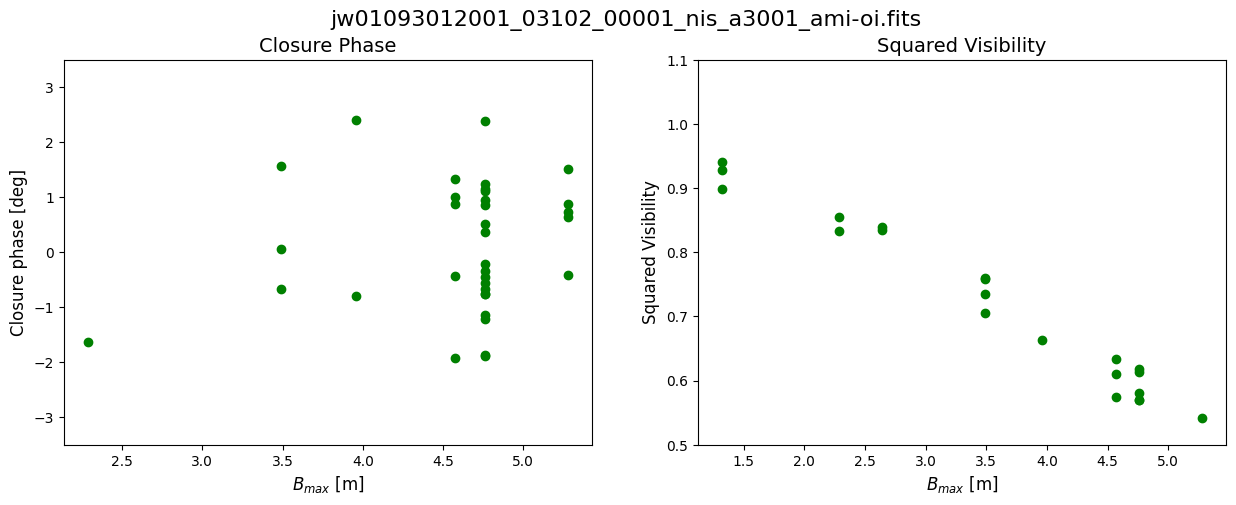

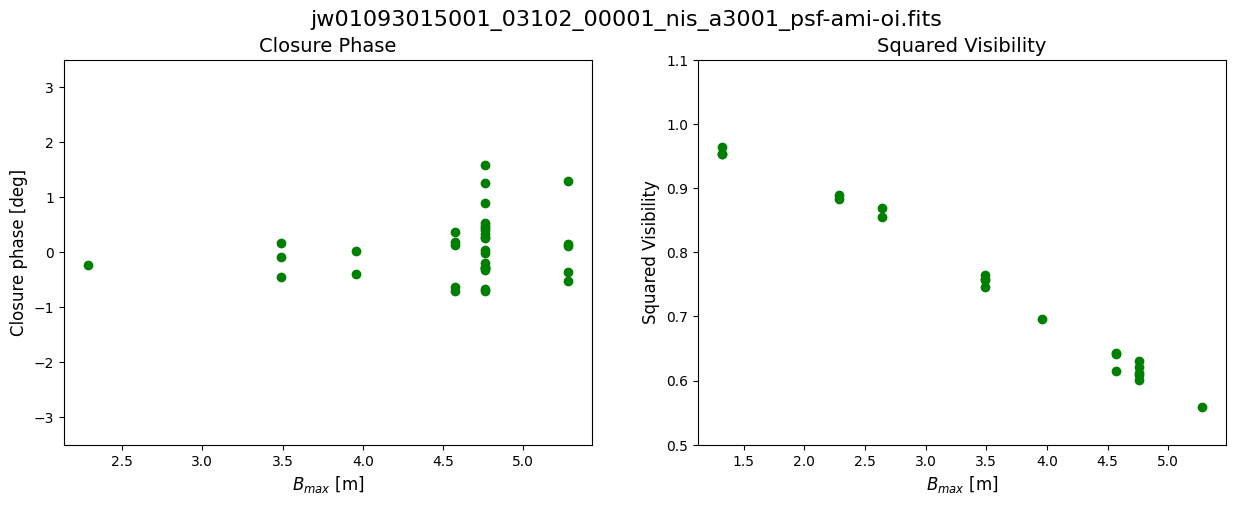

In [39]:
if doviz:
    # Get the first target ami-oi.fits file
    oi_scifile = sorted(glob.glob(os.path.join(ami3_dir, "jw*_ami-oi.fits")))
    if isinstance(oi_scifile, list):
        oi_scifile = oi_scifile[0]
        
    # Get the first PSF reference ami-oi fits file
    oi_psffile = sorted(glob.glob(os.path.join(ami3_dir, "jw*psf-ami-oi.fits")))
    if isinstance(oi_psffile, list):
        oi_psffile = oi_psffile[0]

    # Open them as datamodels
    amioi_targ = datamodels.open(oi_scifile)
    amioi_ref = datamodels.open(oi_psffile)

    # Plot the observables
    plot_observables(amioi_targ)
    plot_observables(amioi_ref)

The top two scatter plots show the observables from the target observation, and the lower two show the observables from the reference star. For a perfect point source observation at single wavelength, we would expect to recover closure phases of zero and squared visibilites of unity. 

Since the closure phases are sensitive to asymmetries in the source brightness distribution, we can tell from the larger scatter of the target that it is likely not a point source; i.e, there is a faint companion. On the other hand, the reference star has closure phases with a much smaller scatter around zero. The squared visibilities of both decrease at longer wavelengths due to an effect called bandpass smearing. We expect that calibrating the target by the reference star should correct for this, as well as other systematics.

Now we will plot the final calibrated data product; the target normalized by the reference star. The reference star closure phases are subtracted from the target closure phases, and the target squared visibilities are divided by the reference star squared visibilities. 

Further scientific analysis on these calibrated OIFITS files can be done with community-developed analysis software like [CANDID](https://github.com/amerand/CANDID) ([Gallenne et al. 2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...579A..68G/abstract)) or [Fouriever](https://github.com/kammerje/fouriever) to extract binary parameters, or an image reconstruction code like [SQUEEZE](https://github.com/fabienbaron/squeeze) ([Baron et al. 2010](https://ui.adsabs.harvard.edu/abs/2010SPIE.7734E..2IB/abstract)) or BSMEM ([Skilling & Bryan 1984](https://ui.adsabs.harvard.edu/abs/1984MNRAS.211..111S/abstract), [Buscher 1994](https://ui.adsabs.harvard.edu/abs/1994IAUS..158...91B/abstract), [Baron & Young 2008](https://ui.adsabs.harvard.edu/abs/2008SPIE.7013E..3XB/abstract)).

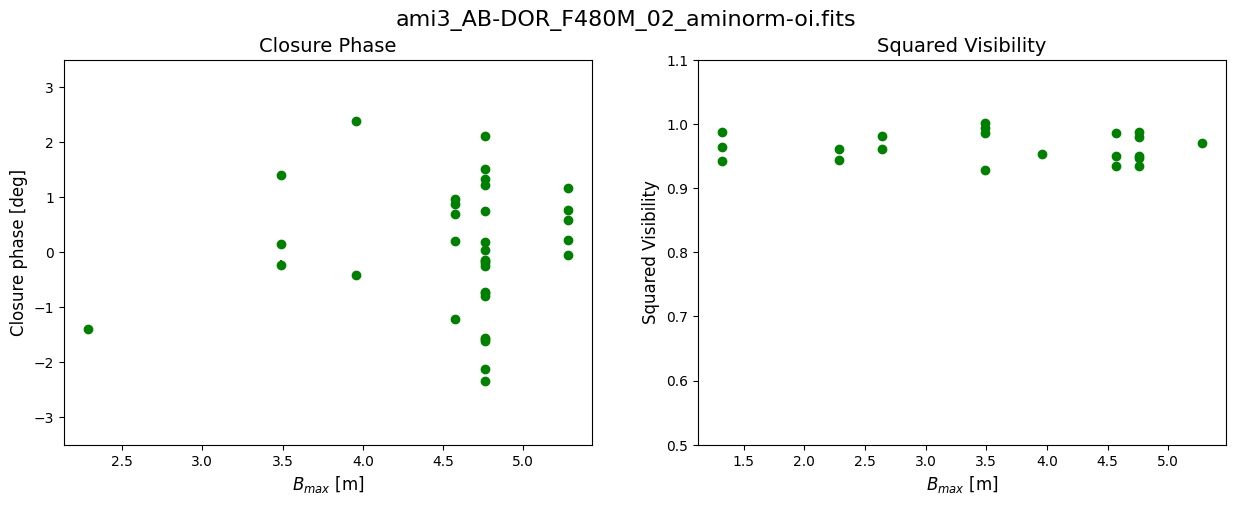

In [40]:
if doviz:
    # Identify calibrated *_aminorm-oi.fits file and open as datamodel
    abdor_oifits = glob.glob(os.path.join(ami3_dir, "*_aminorm-oi.fits"))[0]
    amioi_norm = datamodels.open(abdor_oifits)

    # Plot the observables
    plot_observables(amioi_norm)

### Display the best-fit model

We can also look at the cleaned data, model, and residual images that are saved in the auxiliary `*amilg.fits` data products:

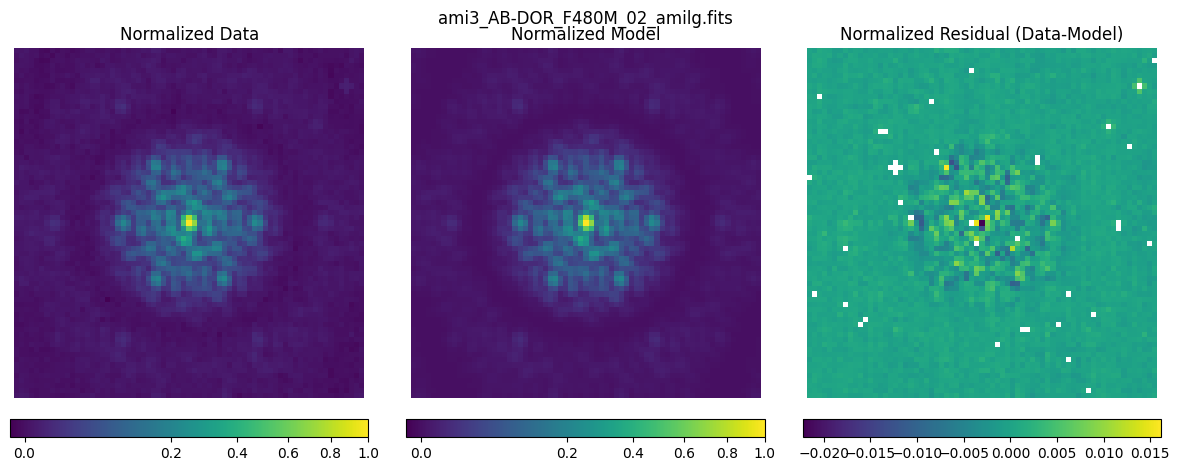

In [41]:
if doviz:
    # Find the data files
    amilg = sorted(glob.glob(os.path.join(ami3_dir, '*amilg.fits')))

    # Open the first one as an AmiLGModel
    firstfile = amilg[0]
    amilgmodel = datamodels.open(firstfile)

    # Plot the data, model, residual
    norm = ImageNormalize(amilgmodel.norm_centered_image[0], 
                          interval=MinMaxInterval(), 
                          stretch=SqrtStretch())
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].set_title('Normalized Data')
    im1 = axs[0].imshow(amilgmodel.norm_centered_image[0], norm=norm)
    axs[1].set_title('Normalized Model')
    im2 = axs[1].imshow(amilgmodel.norm_fit_image[0], norm=norm)
    axs[2].set_title('Normalized Residual (Data-Model)')
    im3 = axs[2].imshow(amilgmodel.norm_resid_image[0])

    for im in [im1, im2, im3]:
        plt.colorbar(im, shrink=.95, location='bottom', pad=.05)
    for ax in axs:
        ax.axis('off')
        
    plt.suptitle(os.path.basename(firstfile))
    plt.tight_layout()

Each image has been normalized by the peak pixel value of the data, and the data and model are displayed on a square root stretch to emphasize the fainter features. By looking at the residual (data - model) image, we can see that the model is a good fit to the data. This model achieves better contrast than ground-based NRM, but has not reached the binary contrast science requirements of AMI. The faint vertical striping in the background of the residual image is 1/f noise (flicker noise), which is an active area of improvement for the NIRISS/AMI team, as is the best method of correcting for charge migration. 

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_footer.png" alt="stsci_logo" width="200px"/> 